# DTSA 5510 Unsupervised Algorithms in Machine Learning Final Project  
### Problem Definition

This project focuses on applying **unsupervised machine learning** techniques to cluster countries based on a set of **socio-economic and health indicators**.  
The aim is to identify groups of countries with similar development profiles in order to inform international aid allocation decisions.  
This is a **clustering problem**, where the model should uncover hidden patterns in the data without using any labels.

---

### Problem Description

**HELP International**, a global humanitarian NGO, has raised **$10 million** in funding.  
The CEO needs to determine **which countries should be prioritized** for receiving aid.  
As a data scientist, your task is to use clustering algorithms to analyze the countries’ development data and recommend the countries most in need of assistance.

By using unsupervised learning, we can form meaningful clusters of countries and guide HELP International in making **data-driven decisions** to strategically deploy their resources.

---

### Problem Topic

- **Type of Learning**: Unsupervised Learning  
- **Task Type**: Clustering  
- **Objective**: Group countries by development indicators to guide aid distribution  
- **Evaluation Metrics**: Silhouette Score, Davies-Bouldin Index, Domain Interpretability

---

### About the Data

The dataset is obtained from [Kaggle: Unsupervised Learning on Country Data](https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data/data). It contains numerical indicators for countries across various development dimensions.

#### Features Overview:
- **Demographic & Economic**:
  - `Country`: Country name  
  - `GDP`: Gross Domestic Product  
  - `Income`: Net income per person  
  - `Exports`: % of GDP  
  - `Imports`: % of GDP  
  - `Inflation`: Consumer price inflation  
  - `Population`: In millions  

- **Health & Human Development**:
  - `Child Mortality`: Deaths under age 5 per 1,000  
  - `Health`: Govt. health spending as % of GDP  
  - `Life Expectancy`: Average years  
  - `Total Fertility`: Avg. number of children per woman

#### Data Type:
- All features are **numerical**  
- Format: **Tabular**  
- Number of Observations: 160+ countries  

---

> **Source**:  
> Kaggle. (2024). *Unsupervised Learning on Country Data*. Retrieved from https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data/data


In [41]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Core data libraries
import numpy as np
import pandas as pd

# Scalers & decomposition
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

# Clustering algorithms & evaluation metrics
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

# Visualization: 2D & 3D
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Interactive maps
import plotly.express as px
# For exporting Plotly figures as static images, ensure kaleido is installed:
!pip install -U kaleido
import kaleido

# Display settings
pd.options.display.float_format = '{:.2f}'.format
sns.set(style='whitegrid')

# 1. Exploratory Data Inspection

The following code performs an initial inspection of the dataset to understand its structure and content:

- **Read the data**: Loads the dataset from a CSV file using `pandas.read_csv()`.
- **Preview**: Displays the first five rows using `head()` to get a quick look at the data.
- **Shape**: Prints the number of rows and columns to understand dataset size.
- **Column Names**: Lists all available features for reference.
- **Data Types and Null Checks**: Uses `info()` to display data types, non-null counts, and memory usage.
- **Summary Statistics**: Uses `describe()` to summarize the distribution of numerical features (mean, min, max, std, etc.).


In [42]:
# Load dataset
data = pd.read_csv('../input/unsupervised-learning-on-country-data/Country-data.csv')

# Display the first 5 rows of the dataset
print(data.head())

# Show the number of rows and columns
print(f"Dataset shape: {data.shape}")

# List all column names
print(f"Columns: {data.columns.tolist()}")

# Display data type and non-null count for each column
print("\nDataset Info:")
data.info()

# Generate descriptive statistics for numerical columns
print("\nSummary Statistics:")
print(data.describe())

               country  child_mort  exports  health  imports  income  \
0          Afghanistan       90.20    10.00    7.58    44.90    1610   
1              Albania       16.60    28.00    6.55    48.60    9930   
2              Algeria       27.30    38.40    4.17    31.40   12900   
3               Angola      119.00    62.30    2.85    42.90    5900   
4  Antigua and Barbuda       10.30    45.50    6.03    58.90   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44       56.20       5.82    553  
1       4.49       76.30       1.65   4090  
2      16.10       76.50       2.89   4460  
3      22.40       60.10       6.16   3530  
4       1.44       76.80       2.13  12200  
Dataset shape: (167, 10)
Columns: ['country', 'child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null C

### Initial Data Inspection — Insights

After loading the dataset and running initial exploration (`head()`, `info()`, `describe()`), the following insights can be drawn:

#### Dataset Overview
- **Observations**: 167 countries (rows)
- **Features**: 10 variables
- **No missing values**: All columns contain 167 non-null entries
- **Data types**:
  - 9 numerical columns (`float64`/`int64`)
  - 1 categorical column (`country`)

#### Feature Summary (Selected Insights)

1. **Child Mortality** (`child_mort`):
   - **Mean**: ~38 deaths per 1,000 live births
   - **Range**: From **2.6** (very low) to **90.2** (very high)
   - Indicates **large disparity** in child health across countries.

2. **Health Expenditure** (`health`):
   - Mean government health spending is ~6.8% of GDP.
   - **Min** = 0.37%, **Max** = 17.9% → some countries invest very little in health.

3. **Life Expectancy** (`life_expec`):
   - Mean = **70.56 years**
   - Lowest = **32.1 years**, Highest = **82.8 years**
   - Suggests **vast inequality** in health outcomes and overall development.

4. **Income per Capita** (`income`):
   - Mean = \$17,145, Std = \$19,273 → **high variability**
   - Range: \$609 to \$125,000 → data includes both **low-income and high-income** nations.

5. **Inflation**:
   - Varies widely from **-4.2% (deflation)** to **104% (hyperinflation)**
   - Some economies are likely highly unstable.

6. **GDP per Capita** (`gdpp`):
   - Similar to `income`, wide range from **\$299** to **\$105,000**
   - Suggests a mix of **developing and developed** countries.

7. **Fertility Rate** (`total_fer`):
   - Mean = 2.97 children per woman
   - Some countries have high fertility (max = 7.49), indicating potential population pressure.

---

#### Implications for Clustering

- The dataset presents **strong variation** across most indicators.
- This variation is ideal for unsupervised clustering, as it may reveal **distinct country profiles**.
- Features like **child mortality**, **income**, and **life expectancy** are likely to be **key discriminators** among clusters.


# 2. Exploratory Data Analysis

### Distribution of Features

We begin the EDA by examining the distributions of all numerical features:

- `life_expec` shows a **left-skewed** distribution.
- `health` appears to be **normally distributed**.
- Most other features such as `income`, `exports`, `child_mort`, and `gdpp` are **right-skewed**, indicating a large number of low values and few very high values.
- `country` is excluded from distribution plots since it's a categorical identifier.

Understanding these distributions helps in choosing appropriate scaling and transformation methods before clustering.

---

In [43]:
col = list(data.columns)
col.remove('country')
categorical_features = ['country']
numerical_features = [*col]
print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : country
Numerical Features : child_mort exports health imports income inflation life_expec total_fer gdpp


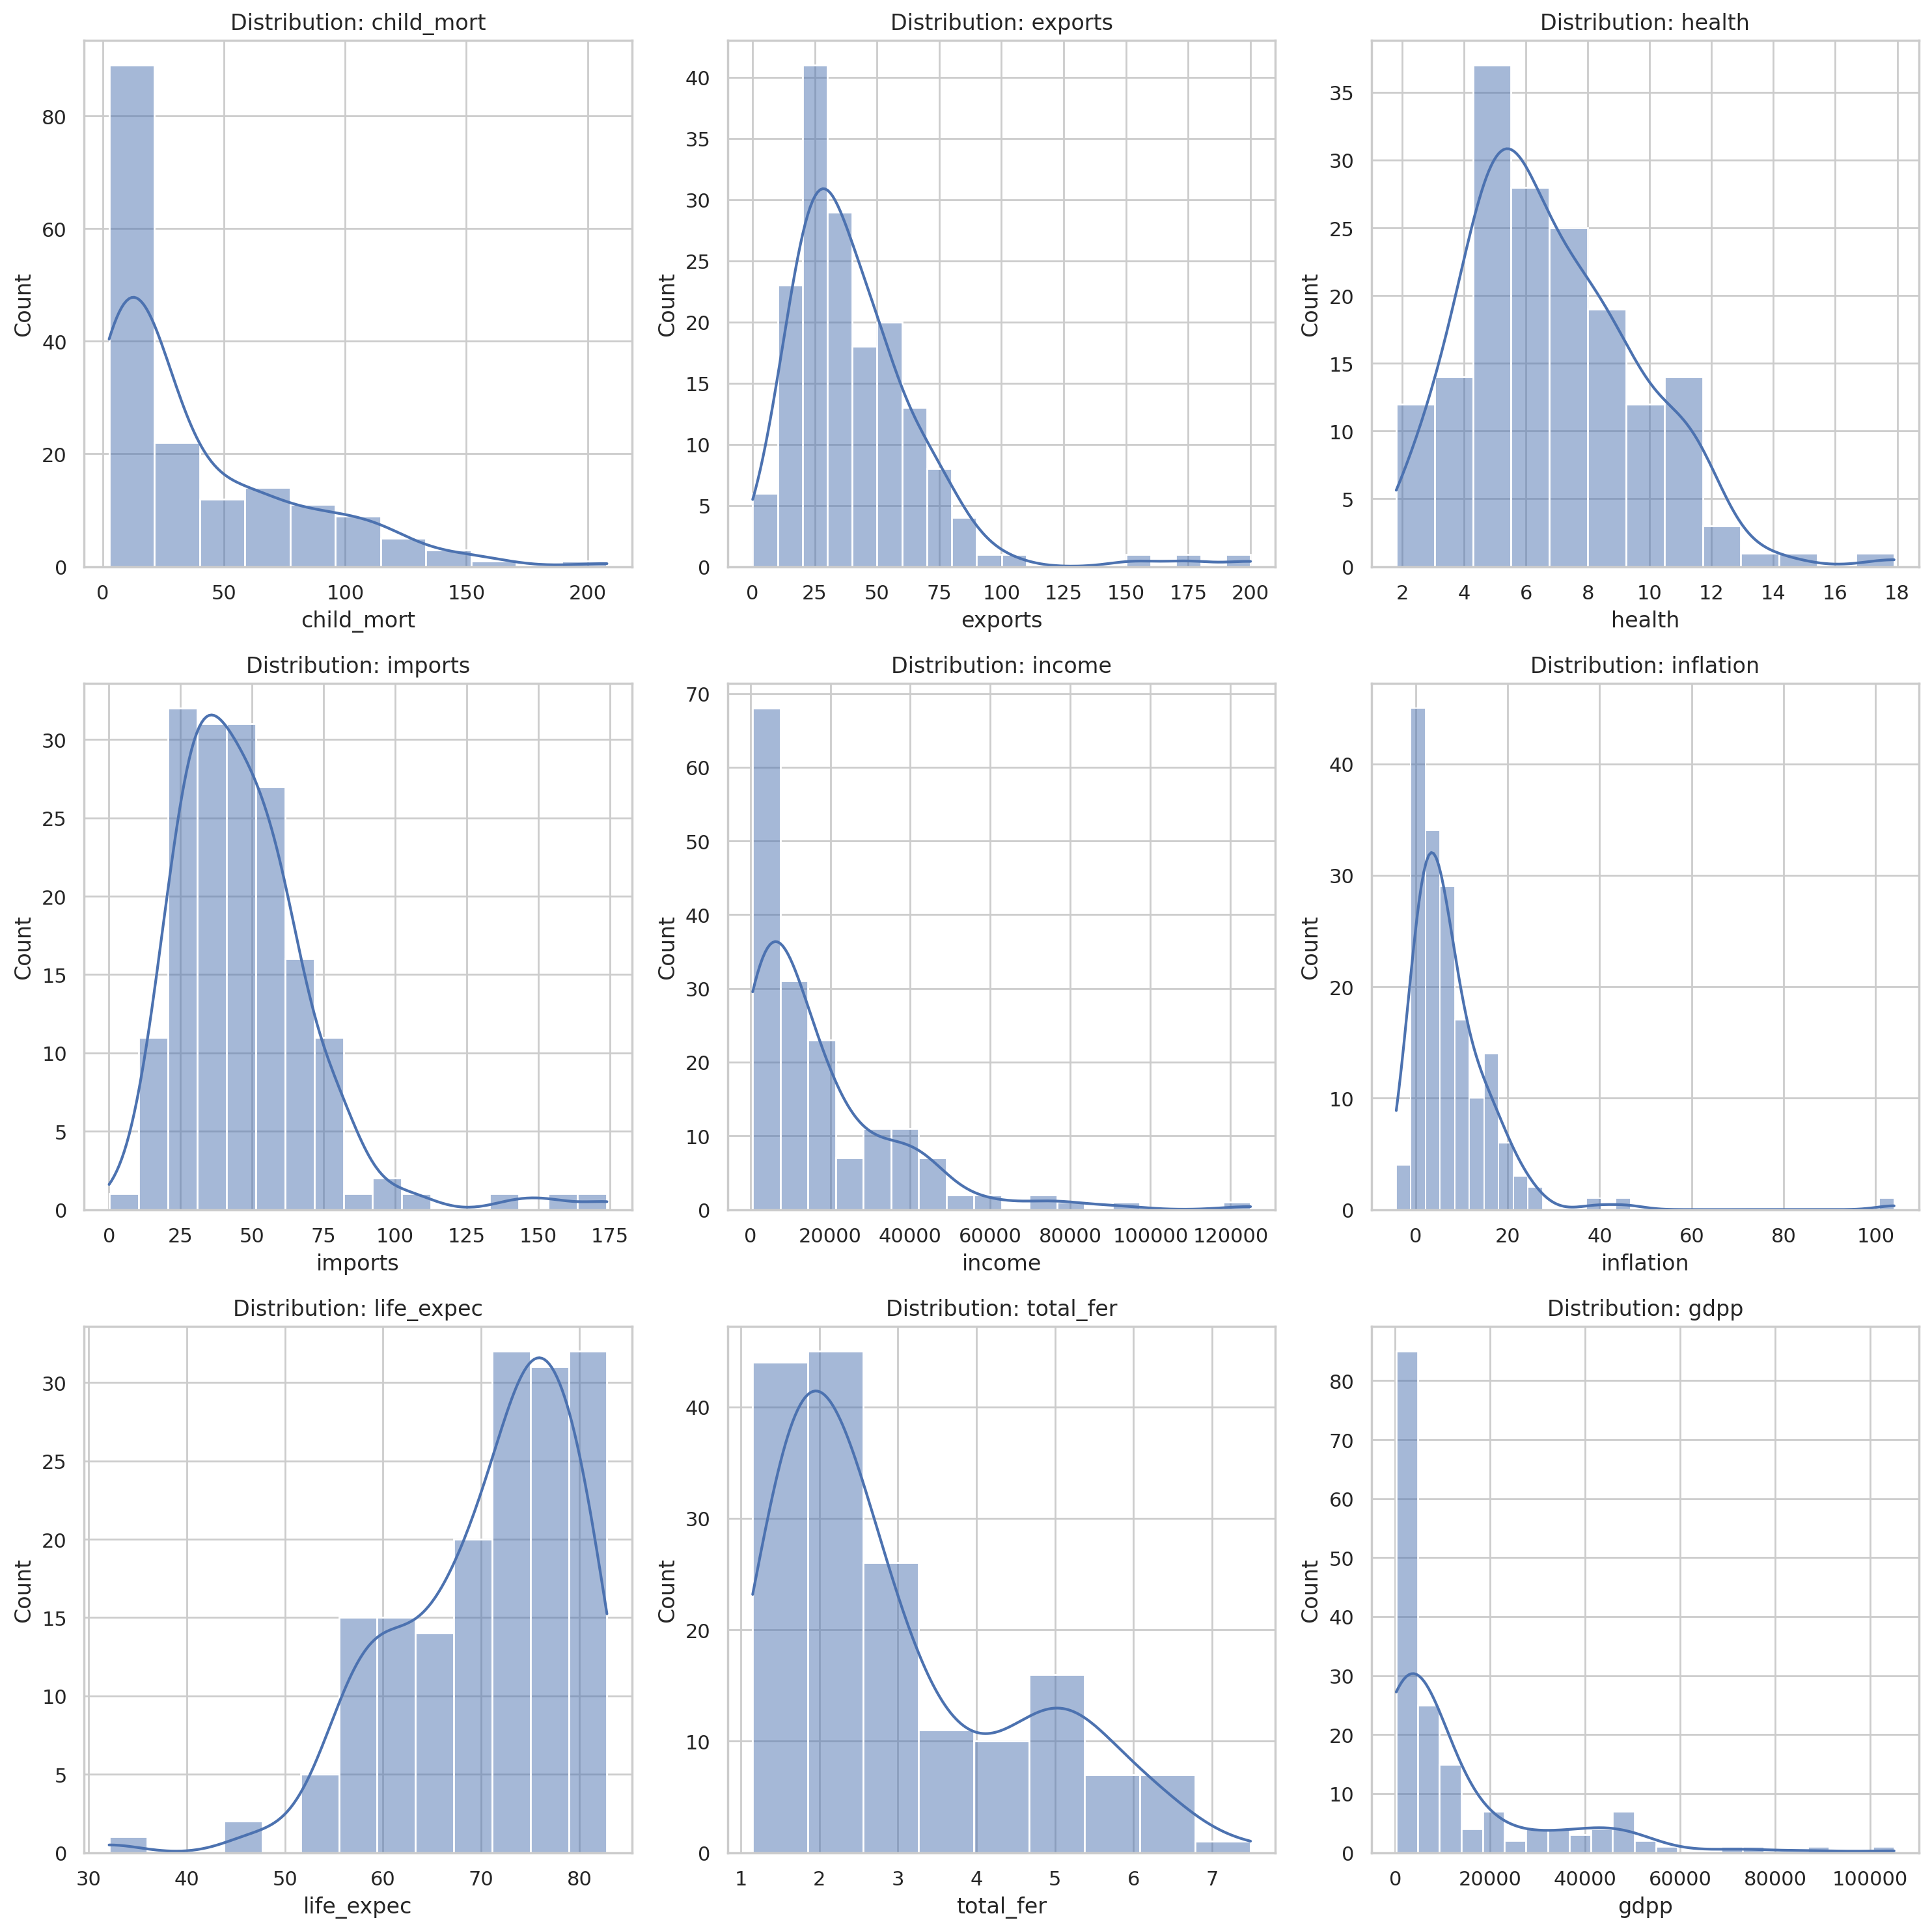

In [44]:
# === Distribution Plots for Numerical Features ===
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution: {feature}')
plt.tight_layout()
plt.show()

### Characteristics of Economically Backward Countries

Based on domain knowledge, economically challenged countries typically exhibit:
- Low income per capita
- High child mortality
- Poor healthcare access
- High fertility and death rates
- Low GDP contribution per person
- Limited exports and imports
- High inflation and low life expectancy

HELP International aims to focus on such countries. To support this, we analyze each feature across three groups:
- Countries with **high** values
- Countries with **median-level** values
- Countries with **low** values

This comparison is visualized using grouped bar charts to show the most and least developed nations for each key variable.

---

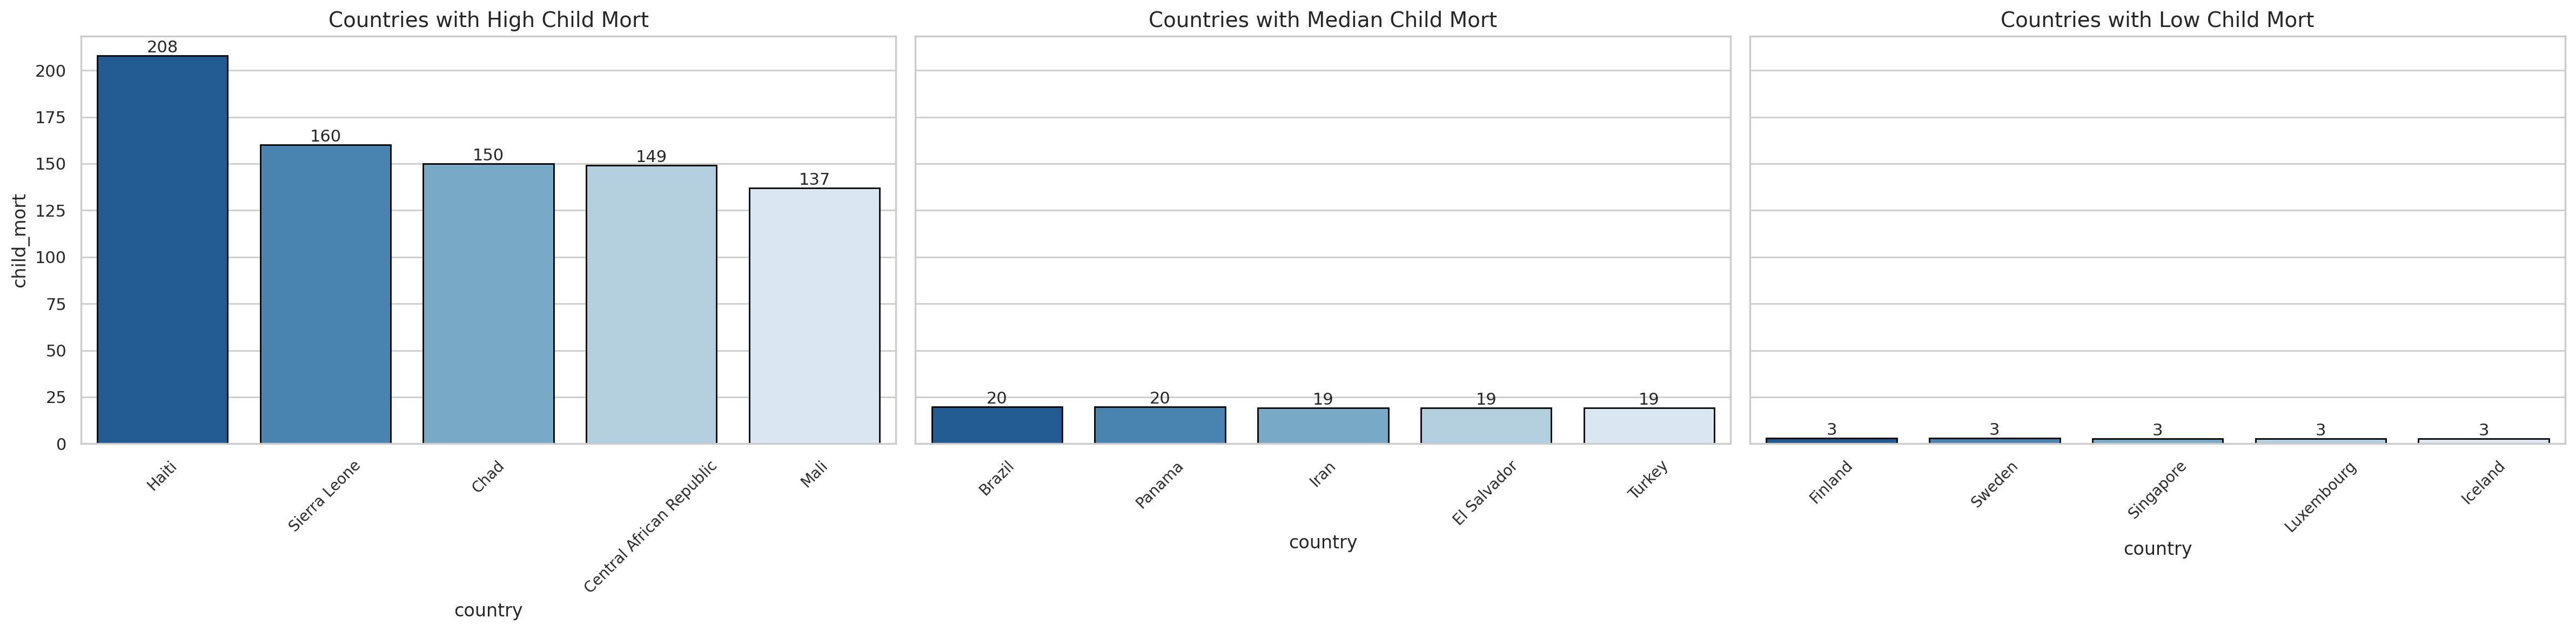

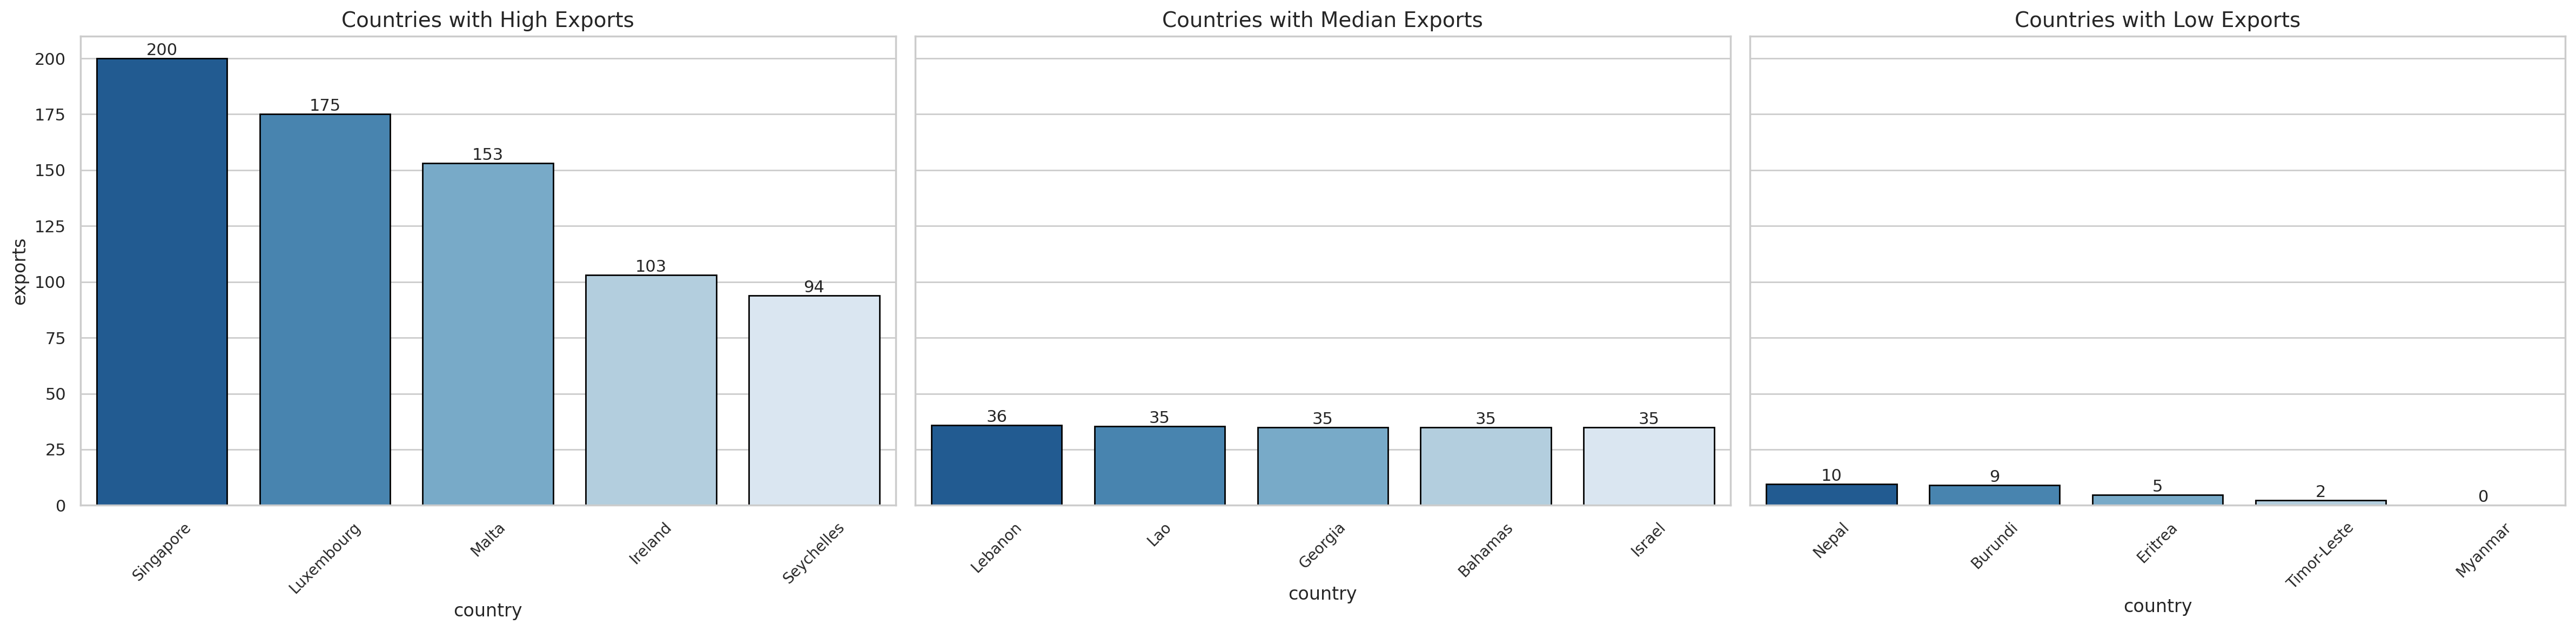

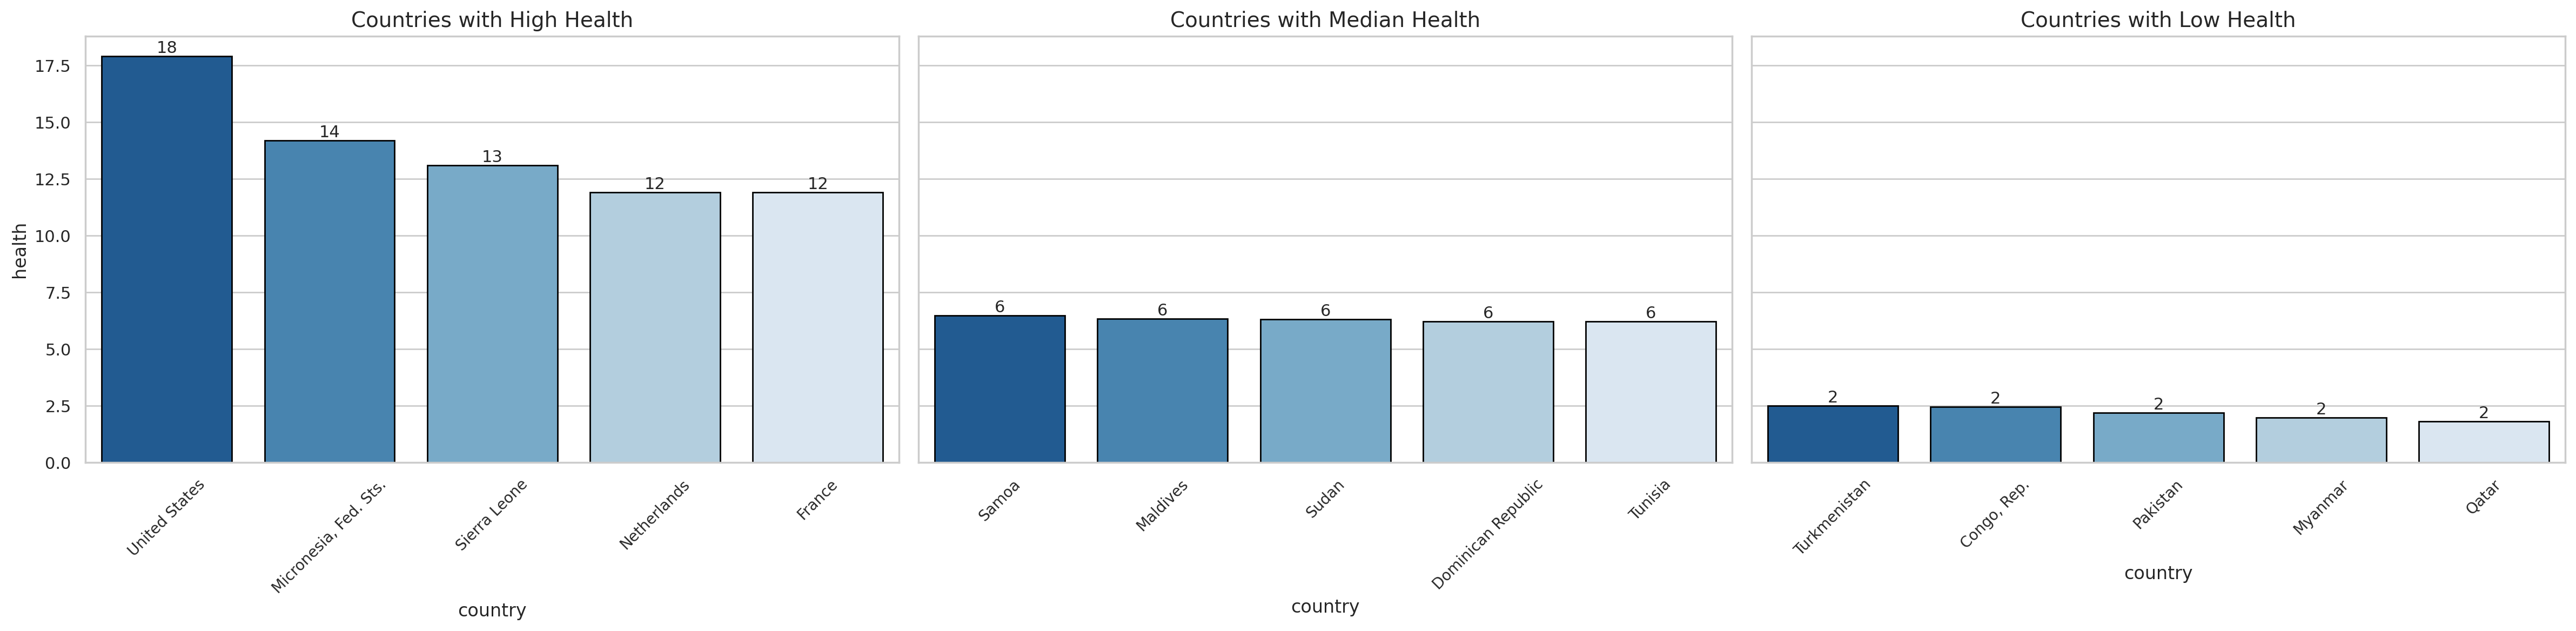

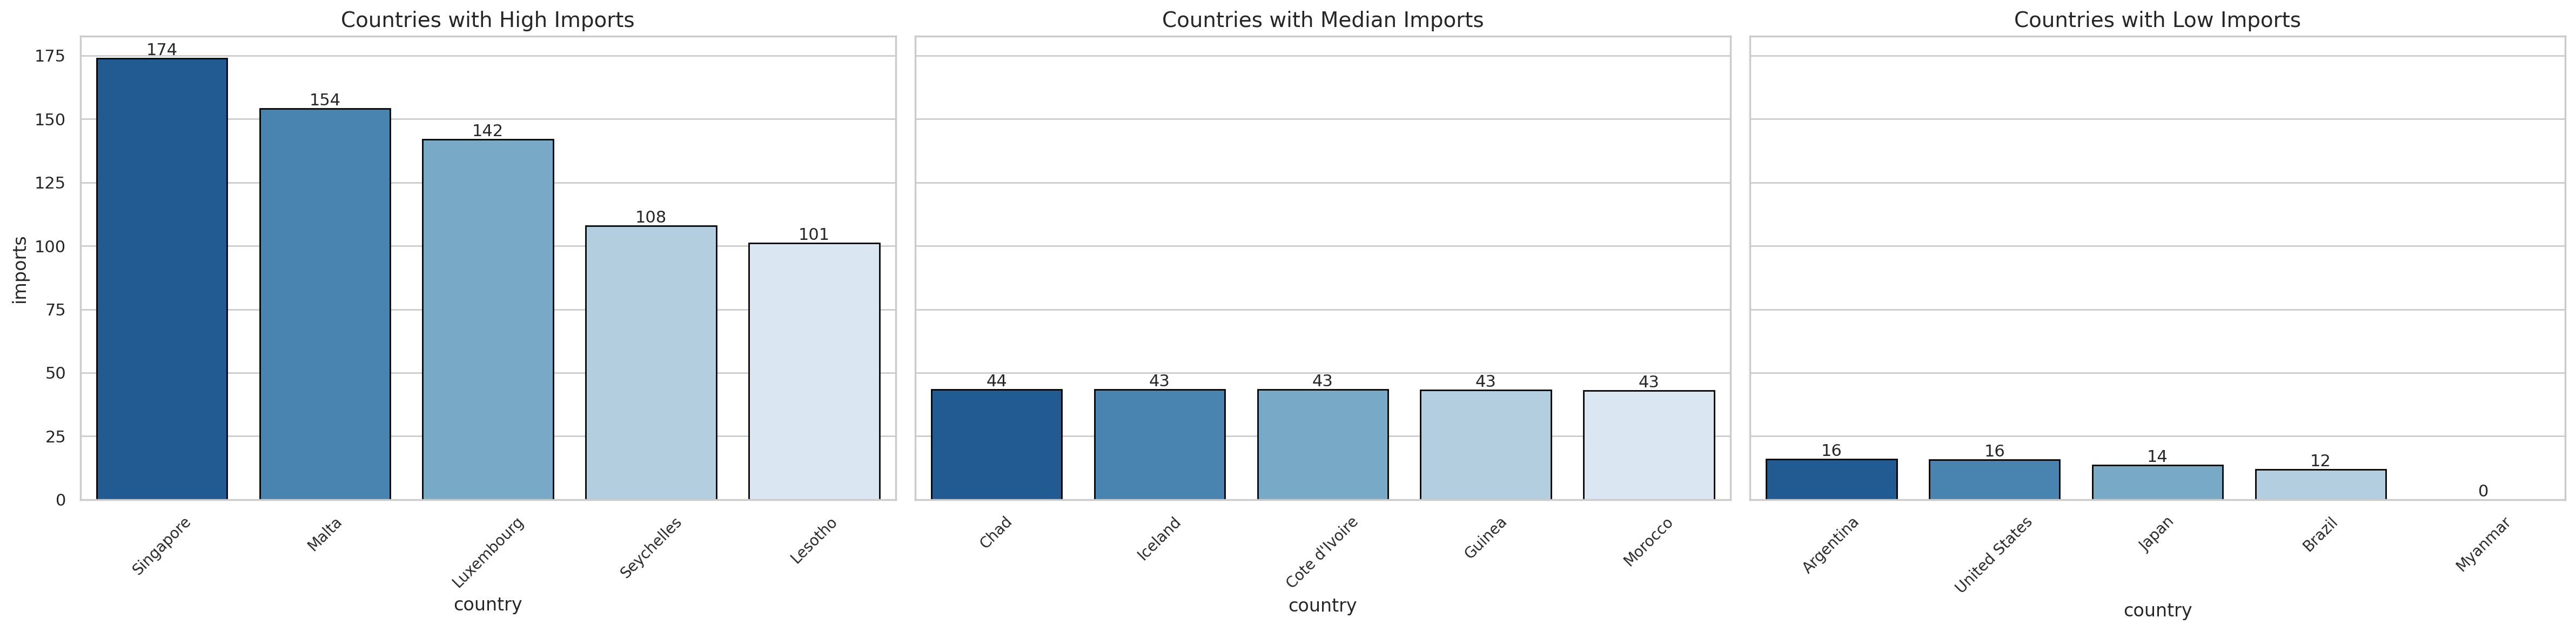

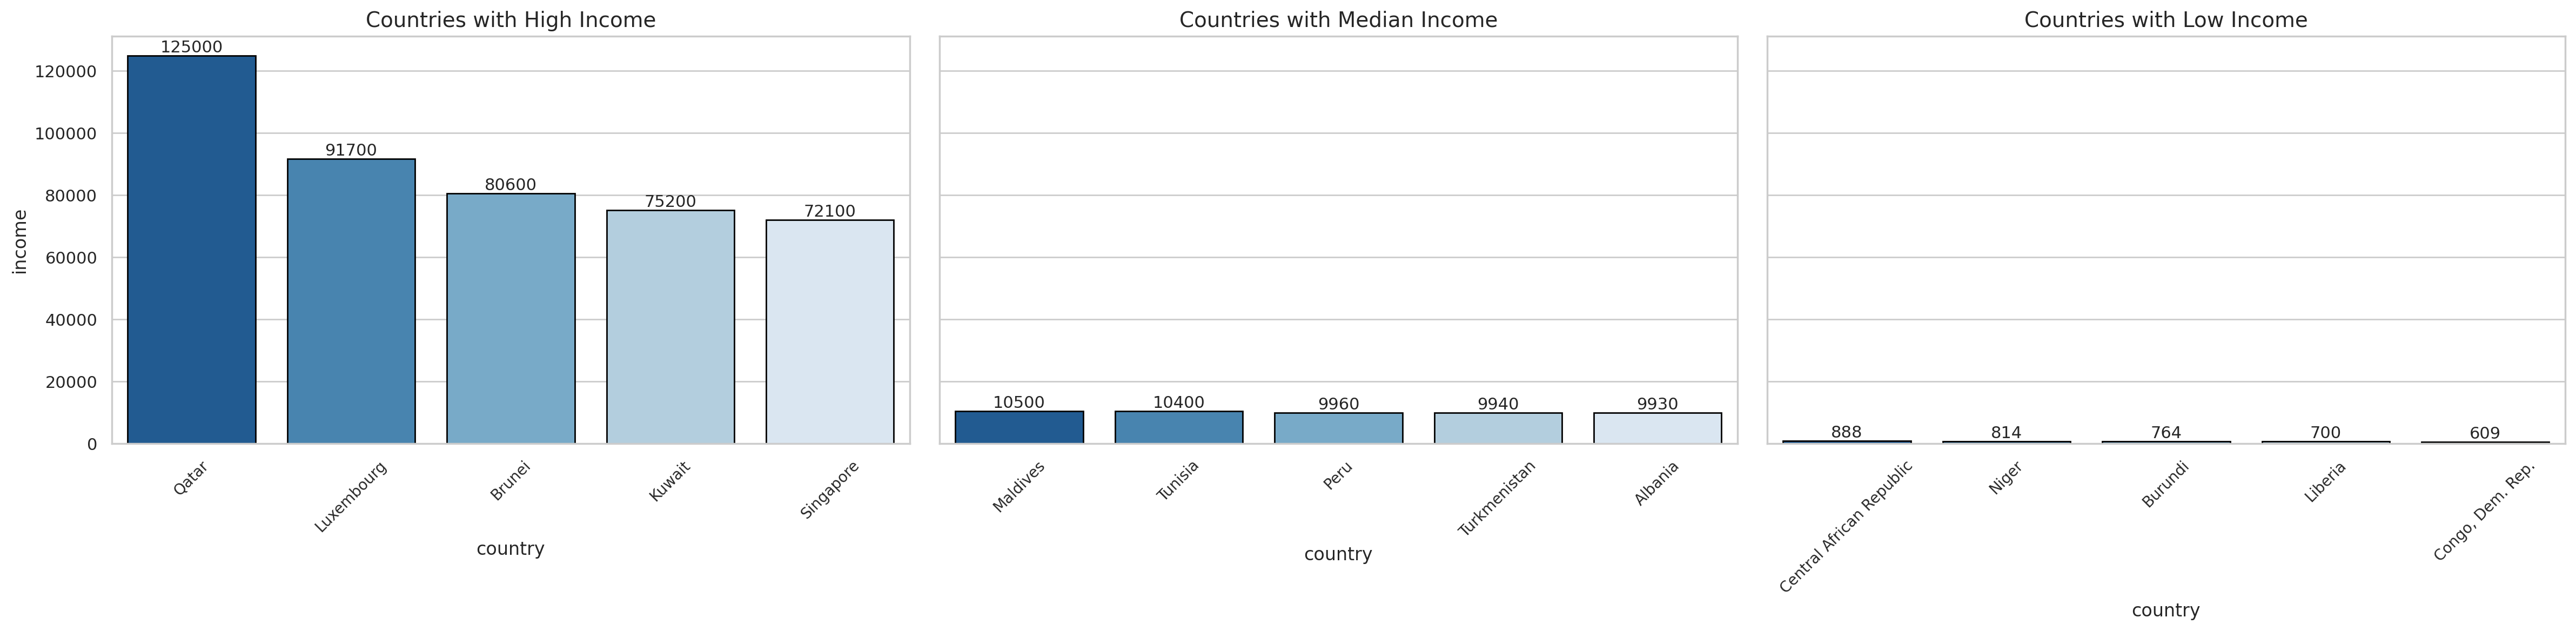

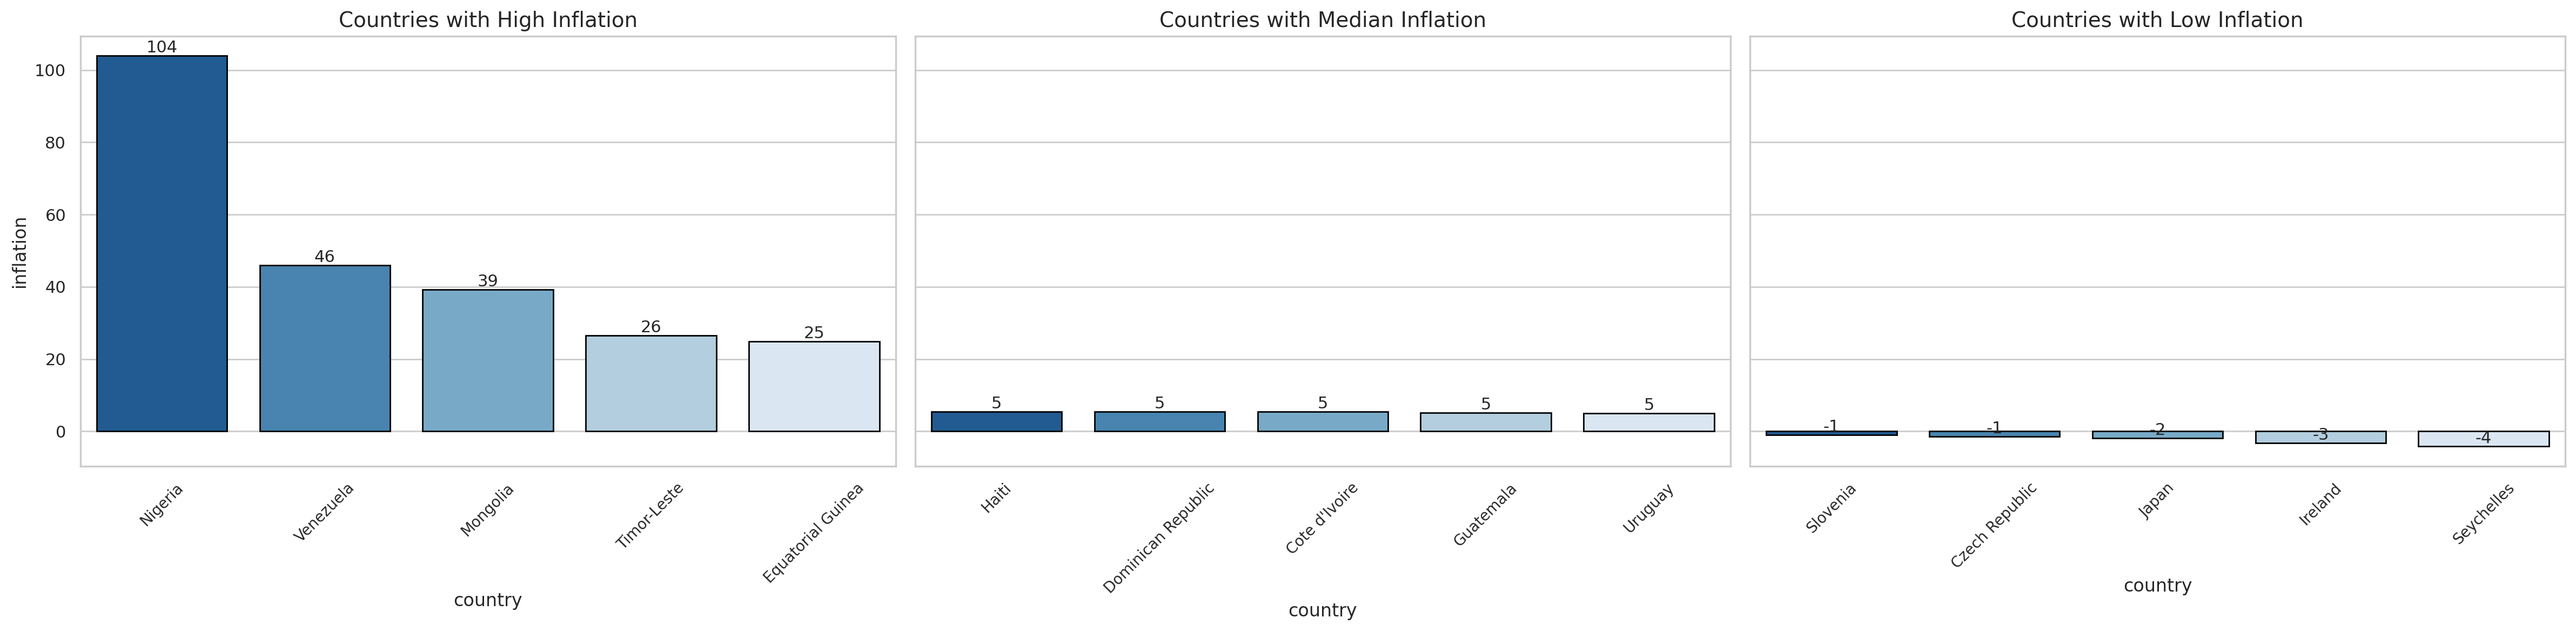

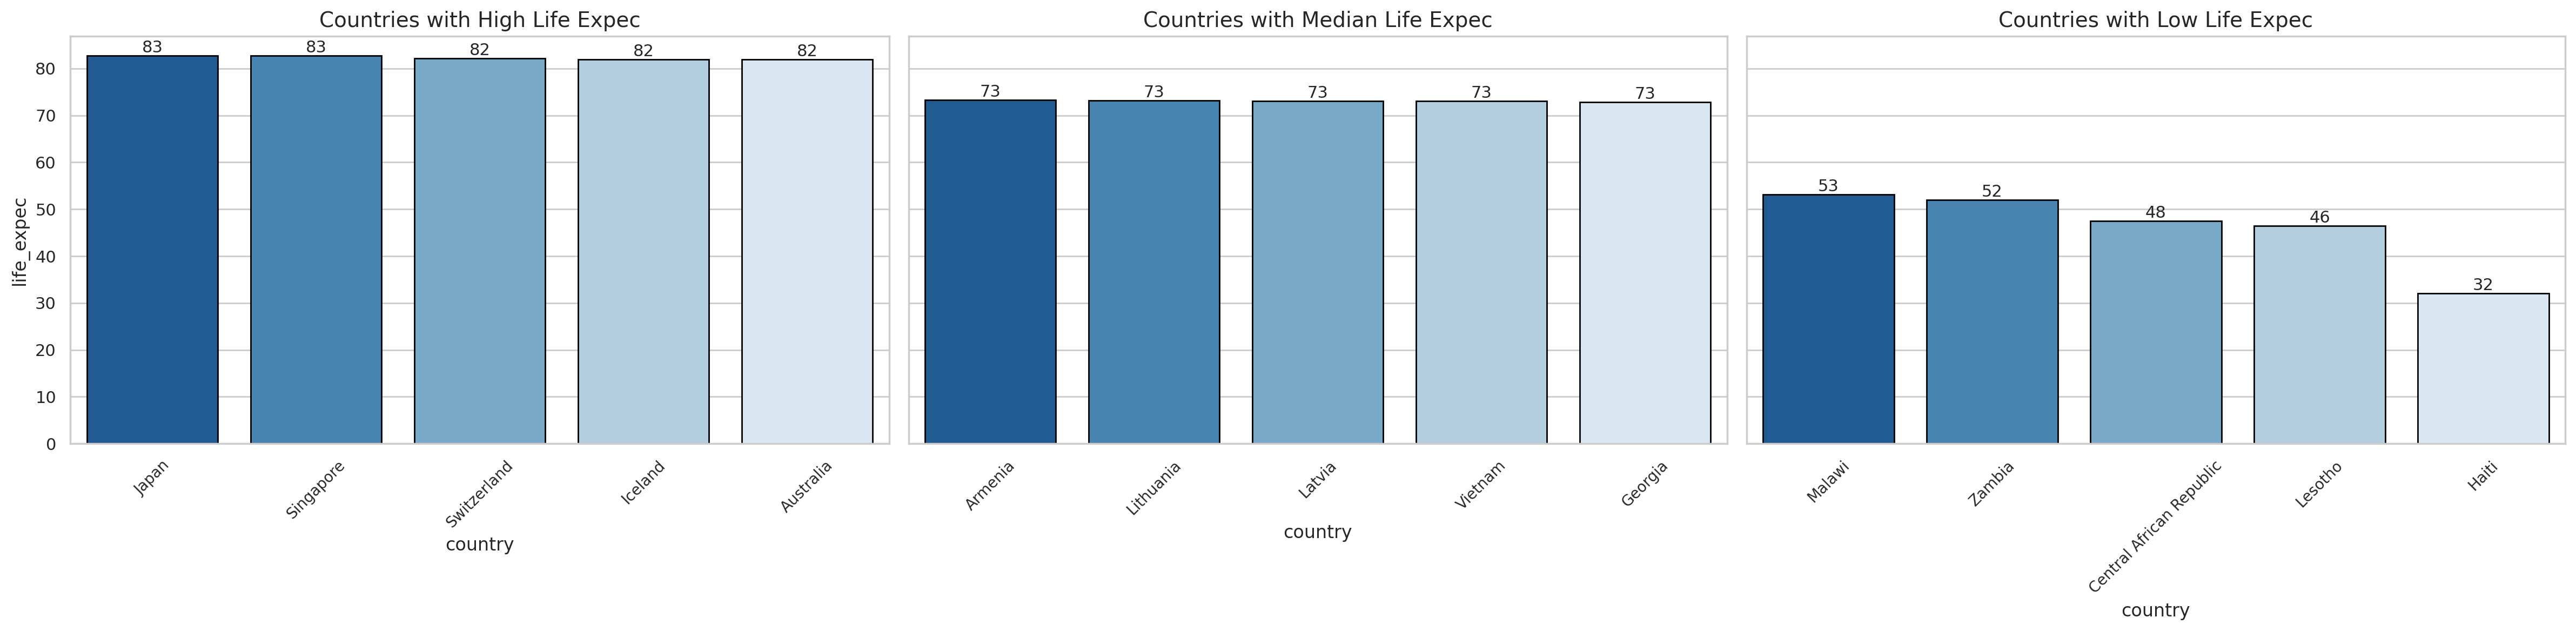

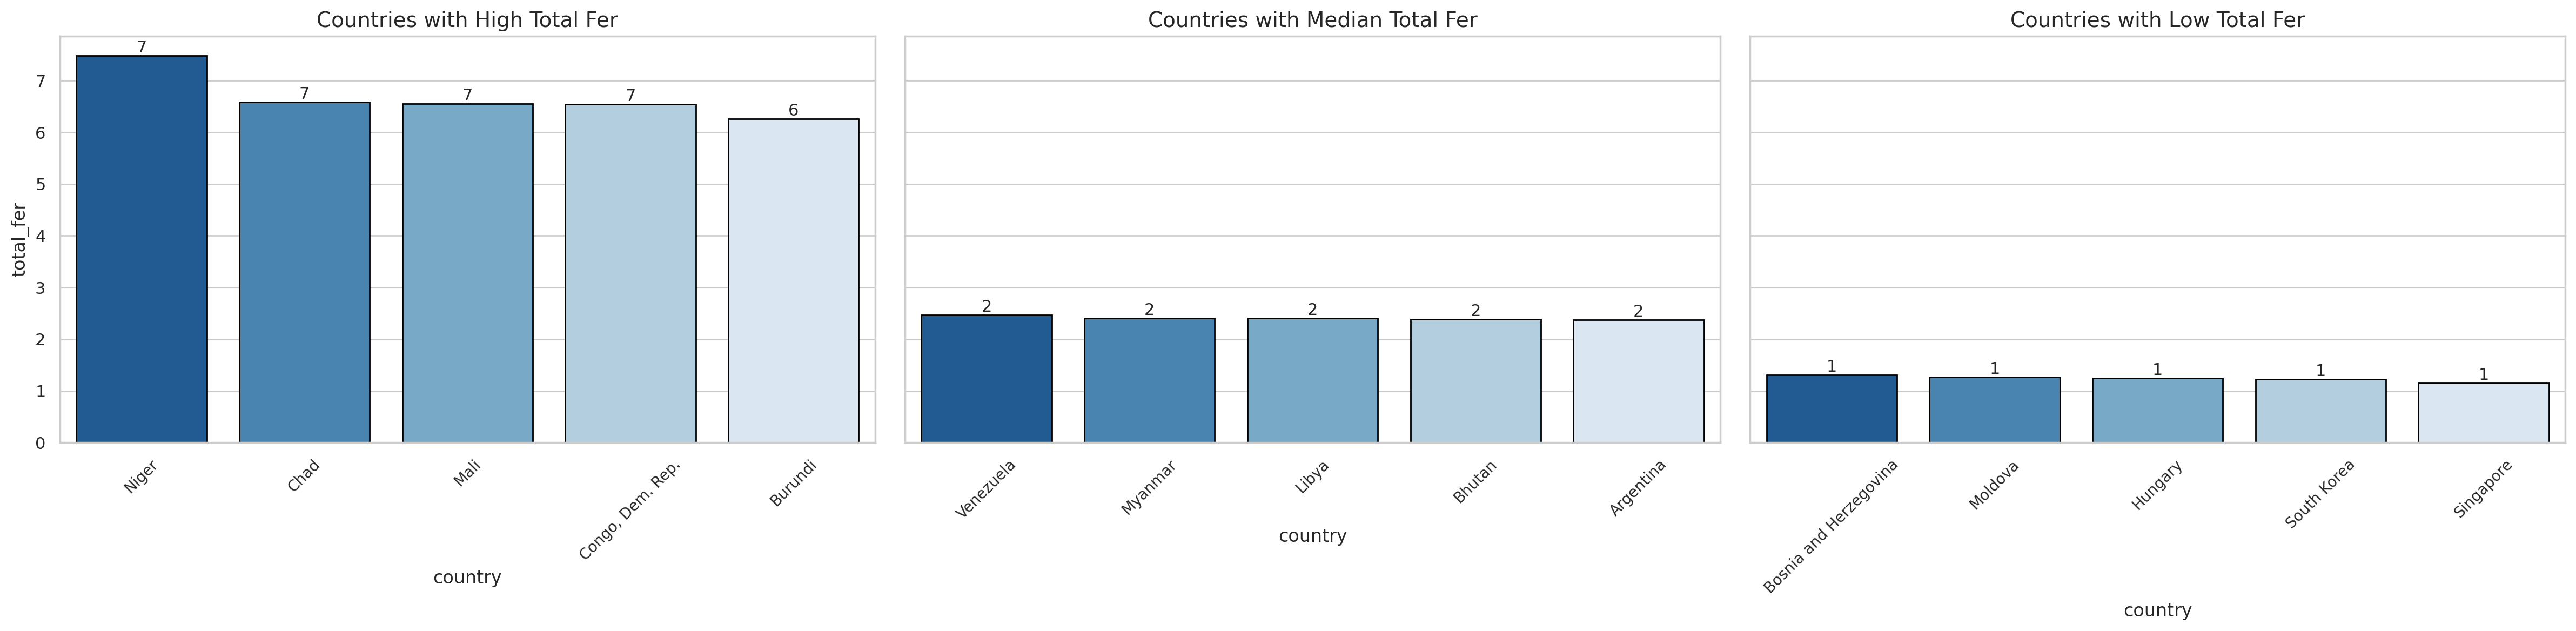

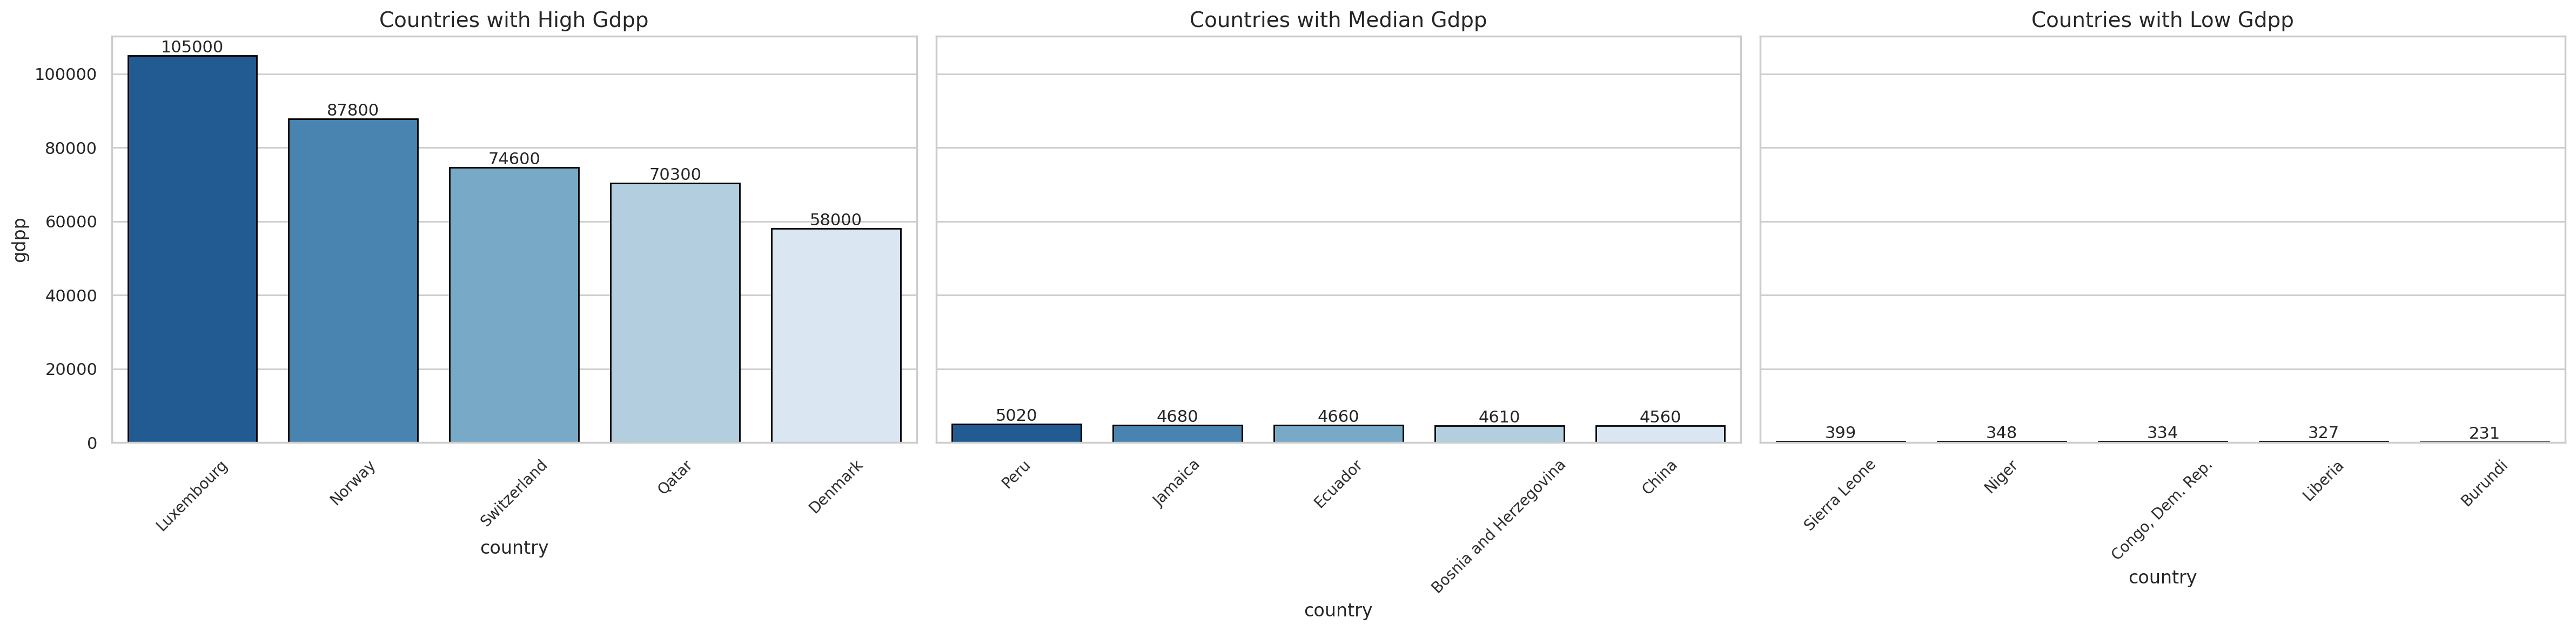

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Visualizing Extreme vs Median Values Across Key Features ===
key_features = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

# Precompute index ranges for High, Median, Low
N = len(data)
mid_start = N // 2 - 2
mid_end   = mid_start + 5
index_ranges = [slice(0, 5), slice(mid_start, mid_end), slice(N-5, N)]
levels = ['High', 'Median', 'Low']

# Create a single 5-color blue palette, then reverse it so darkest is first
blue_palette = sns.color_palette("Blues", 5)[::-1]

for feature in key_features:
    fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
    
    for ax, level, idx in zip(axes, levels, index_ranges):
        subset = data.sort_values(by=feature, ascending=False).iloc[idx]
        
        sns.barplot(
            x='country', y=feature,
            data=subset,
            ax=ax,
            palette=blue_palette,
            edgecolor='black'
        )
        ax.set_title(f'Countries with {level} {feature.replace("_"," ").title()}', fontsize=14)
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        if level == 'High':
            ax.set_ylabel(feature, fontsize=12)
        else:
            ax.set_ylabel('')
        
        # Annotate each bar with its value
        for p in ax.patches:
            ax.annotate(
                f"{p.get_height():.0f}",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=11
            )
    
    plt.tight_layout()
    plt.show()


### Outlier Detection

Boxplots for all numerical features reveal:
- Significant **outliers** in `income`, `gdpp`, `exports`, and `inflation`
- Several features such as `child_mort` and `total_fer` also show **long-tailed distributions**

Outlier detection is crucial prior to clustering to prevent extreme values from skewing distance-based algorithms like K-Means.

---

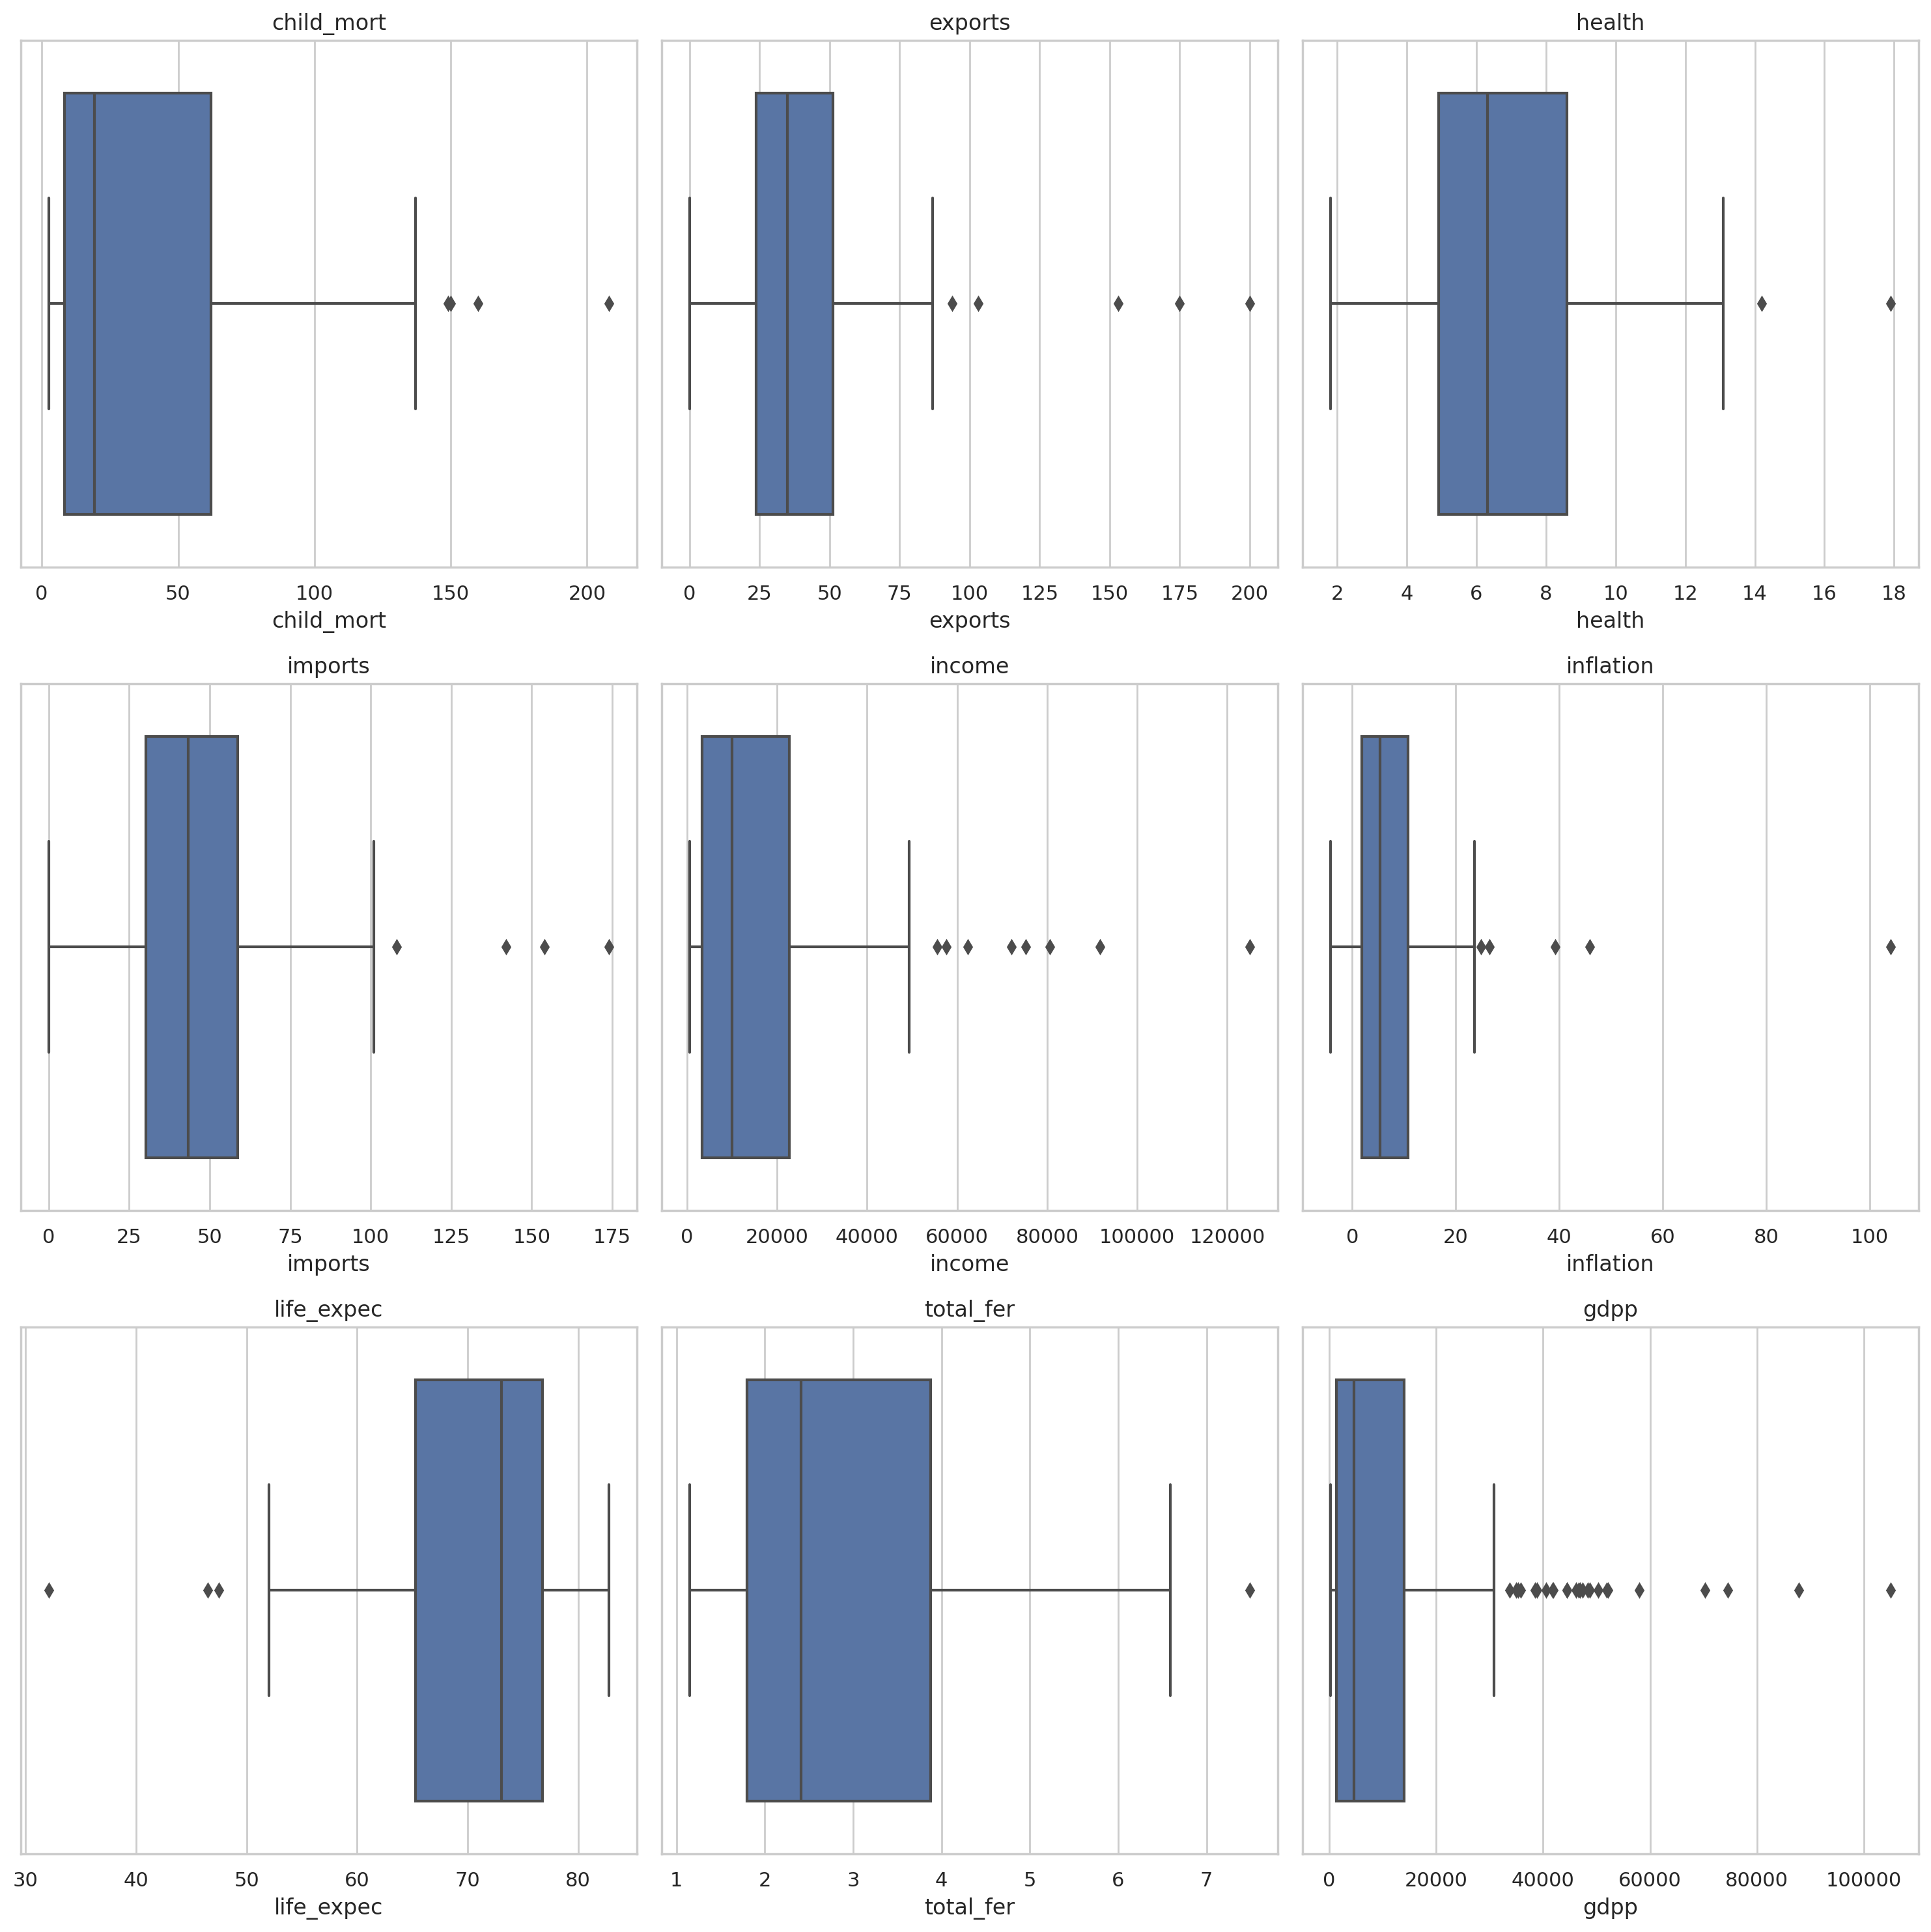

In [46]:
# === Boxplots for Outlier Detection in Numerical Features ===
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=data[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

## Summary of Exploratory Data Analysis (EDA)

Based on visual exploration and economic development indicators, we can derive the following key insights about global socio-economic and health conditions:

### Regional Disparities

- **African countries** consistently rank poorly across multiple development indicators:
  - High **child mortality** (`child_mort`)
  - Low **life expectancy** (`life_expec`)
  - High **fertility rates** (`total_fer`)
  - These trends highlight critical challenges and justify targeted aid, especially during unforeseen crises.
  - **Haiti**, although not in Africa, shows the highest child mortality rate.

- **Asian and European countries** generally appear on the favorable end of health and demographic metrics.


### Health Spending vs Outcomes

- **USA** ranks highest in **health expenditure** (`health`), yet does **not** appear among the top countries in **life expectancy** or **fertility control**.
- None of the top 5 countries in **life expectancy** are top health spenders — this suggests that **health outcomes are not solely driven by spending**, but by efficiency and access as well.
- **Asian countries** dominate the **lower end** of health spending, reflecting different national priorities or resource constraints.

### Trade (Exports & Imports)

- Countries like **Singapore, Malta, Luxembourg**, and **Seychelles** appear in the **top 5** for both **exports** and **imports**.
- These nations tend to be **small but highly connected**, relying heavily on international trade.
- **Sudan** is the only African country among the **lowest importers**, and **Brazil** ranks as the **lowest overall** in imports — both due to internal market focus or geographical/political factors.


### Economic Indicators (Income & GDPP)

- **Qatar** has the **highest income per capita**, with **Singapore** and **Luxembourg** also ranking high.
- **Luxembourg** leads in **GDP per capita**, followed by **Switzerland** and **Qatar** — highlighting these as global economic leaders.
- **African nations** are overrepresented at the **bottom of both income and GDPP** rankings, a lingering effect of historical colonization and systemic underdevelopment.


### Inflation Rates

- **High inflation** is concentrated in **African countries**, indicating economic instability and monetary challenges.
- **Low inflation** is more widely distributed across continents, including both developed and emerging economies.


### Key Takeaway

The analysis reveals **sharp disparities between countries** in terms of health, economic prosperity, and trade. These findings are crucial for informing **clustering and prioritization** of aid distribution by HELP International. Regions with consistently low rankings across multiple indicators — particularly in **Africa** — should be the **primary focus** for development support.

# 3. Feature Engineering

### Correlation Matrix

We start by examining pairwise correlations between features:

- `child_mort` is **negatively correlated** with `income`, `gdpp`, and `exports`, and **positively correlated** with `inflation`.
- `income` and `gdpp` show a very strong **positive correlation (0.9)**, which suggests redundancy.
- `health` expenditure shows a small **positive effect** on `life_expec` and a **negative association** with `child_mort`.
- `inflation` is **negatively associated** with economic metrics and **positively with fertility and child mortality**, capturing typical traits of underdeveloped nations.
- `life_expec` and `total_fer` are **negatively correlated**, as expected in development theory.

These relationships indicate **overlapping dimensions**, so we group them accordingly.

---

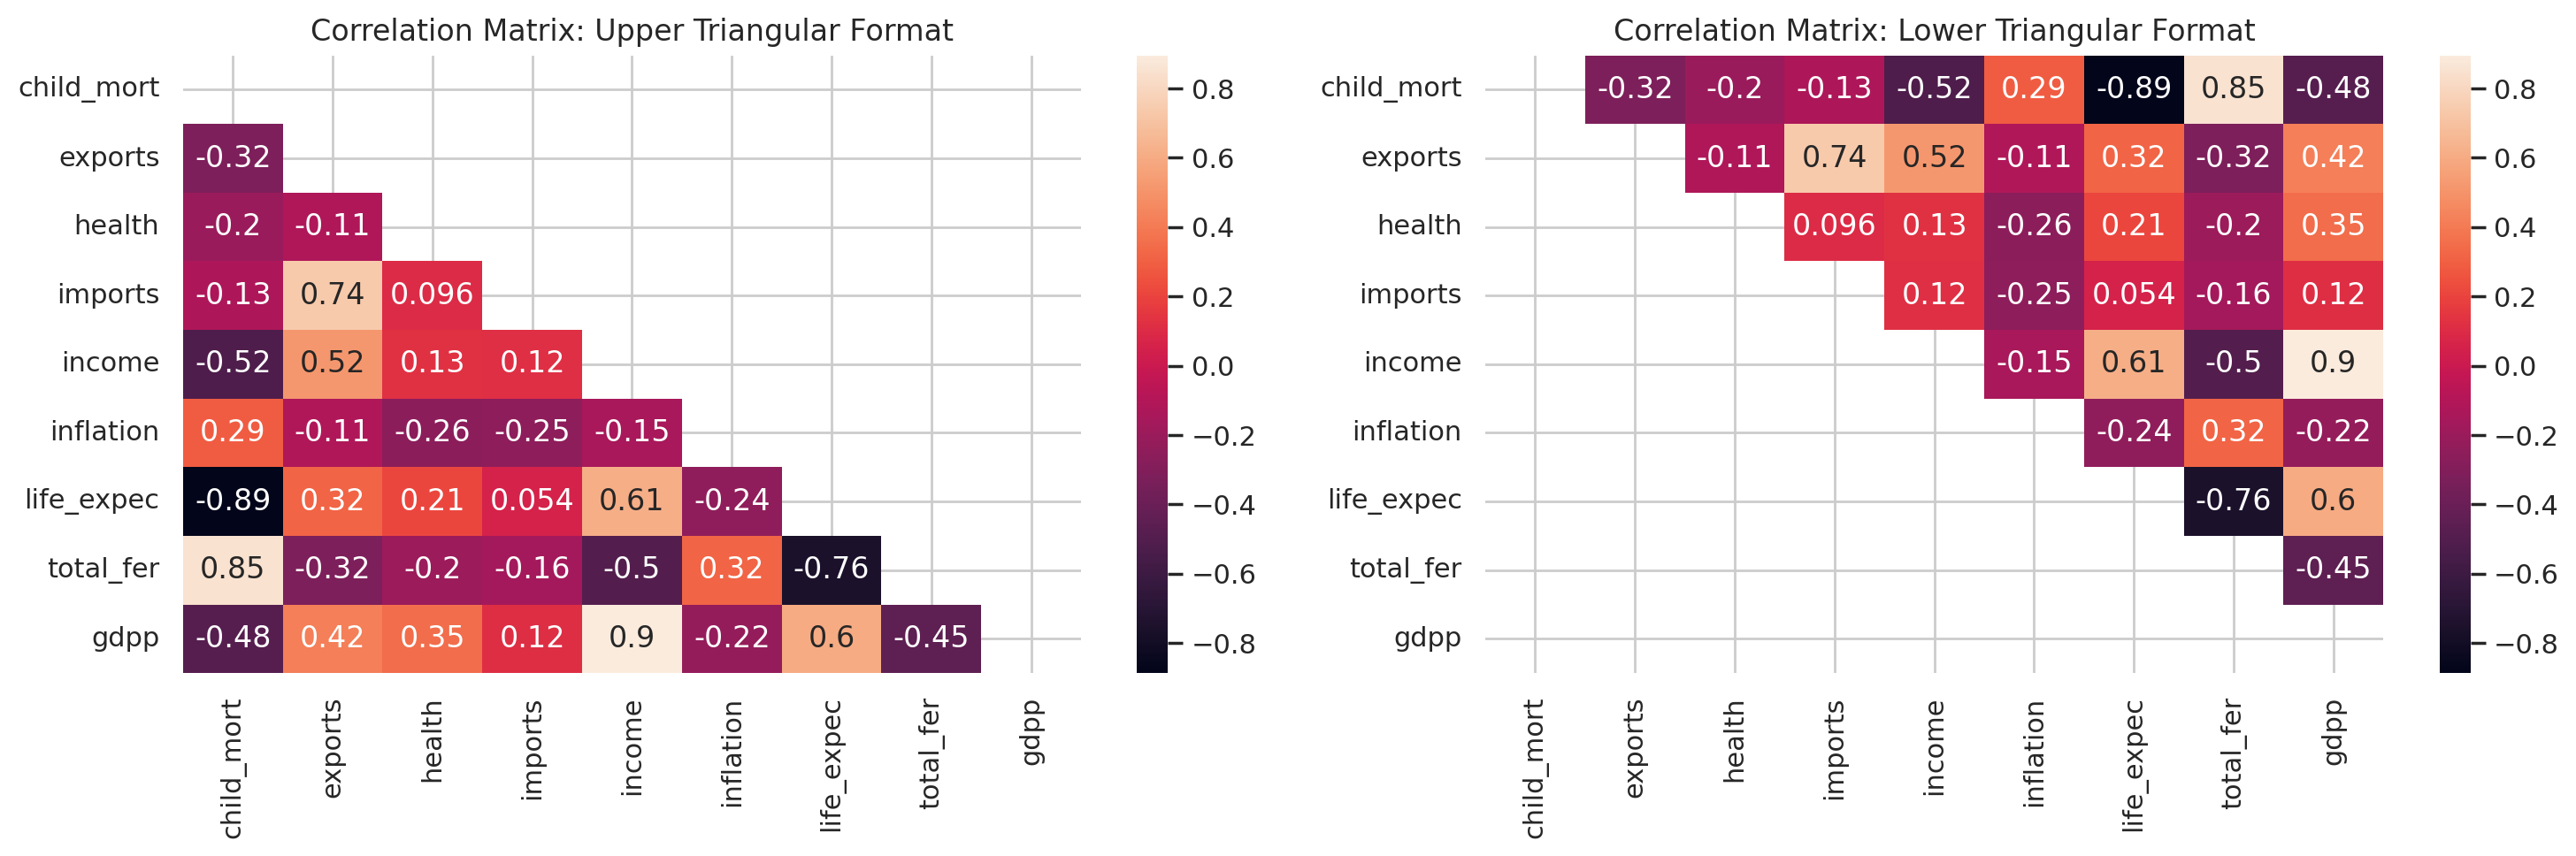

In [47]:
# === Correlation Matrix ===
numeric_data = data.drop(columns=['country'])
corr_matrix = numeric_data.corr()
upper_triangle = np.triu(corr_matrix)
lower_triangle = np.tril(corr_matrix)

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
sns.heatmap(corr_matrix, annot=True, cbar=True, mask=upper_triangle, ax=ax[0])
ax[0].set_title('Correlation Matrix: Upper Triangular Format')

sns.heatmap(corr_matrix, annot=True, cbar=True, mask=lower_triangle, ax=ax[1])
ax[1].set_title('Correlation Matrix: Lower Triangular Format')
plt.tight_layout()
plt.show()

### Feature Grouping: Health, Trade, Finance

To simplify the feature space and improve interpretability, we construct three composite features:

- **Health**: Combines `child_mort`, `health`, `life_expec`, `total_fer`
- **Trade**: Includes `imports` and `exports`
- **Finance**: Aggregates `income`, `inflation`, and `gdpp`

Each component is normalized by its mean before summing to maintain scale balance.

---

In [48]:
# === Feature Grouping: Health, Trade, Finance ===
df1 = pd.DataFrame()
df1['Health'] = (
    data['child_mort'] / data['child_mort'].mean() +
    data['health'] / data['health'].mean() +
    data['life_expec'] / data['life_expec'].mean() +
    data['total_fer'] / data['total_fer'].mean()
)
df1['Trade'] = (
    data['imports'] / data['imports'].mean() +
    data['exports'] / data['exports'].mean()
)
df1['Finance'] = (
    data['income'] / data['income'].mean() +
    data['inflation'] / data['inflation'].mean() +
    data['gdpp'] / data['gdpp'].mean()
)

### Data Scaling

Since machine learning algorithms are sensitive to feature scales, we normalize all newly constructed features using **Min-Max Scaling**.

- This ensures all values lie within [0, 1]
- Helps **distance-based algorithms** like K-Means perform optimally
- Standardization is used only where the distribution is roughly Gaussian (e.g., `health` in the PCA step)

---

In [49]:
# === Scaling the Composite Features (Normalization) ===
mms = MinMaxScaler()
df1['Health'] = mms.fit_transform(df1[['Health']])
df1['Trade'] = mms.fit_transform(df1[['Trade']])
df1['Finance'] = mms.fit_transform(df1[['Finance']])
df1.insert(0, 'Country', data['country'])
print(df1.head())

               Country  Health  Trade  Finance
0          Afghanistan    0.63   0.14     0.08
1              Albania    0.13   0.20     0.09
2              Algeria    0.18   0.19     0.21
3               Angola    0.66   0.28     0.24
4  Antigua and Barbuda    0.12   0.28     0.15


### Principal Component Analysis (PCA)

PCA is applied to the full dataset (excluding `country`):

- `health` is **standardized**
- All other features are **normalized**

We then compute the **explained variance** of each principal component. The first **3 components** capture the majority of the variance (visually observed from the elbow in the cumulative variance plot), and thus are retained for downstream clustering.

---

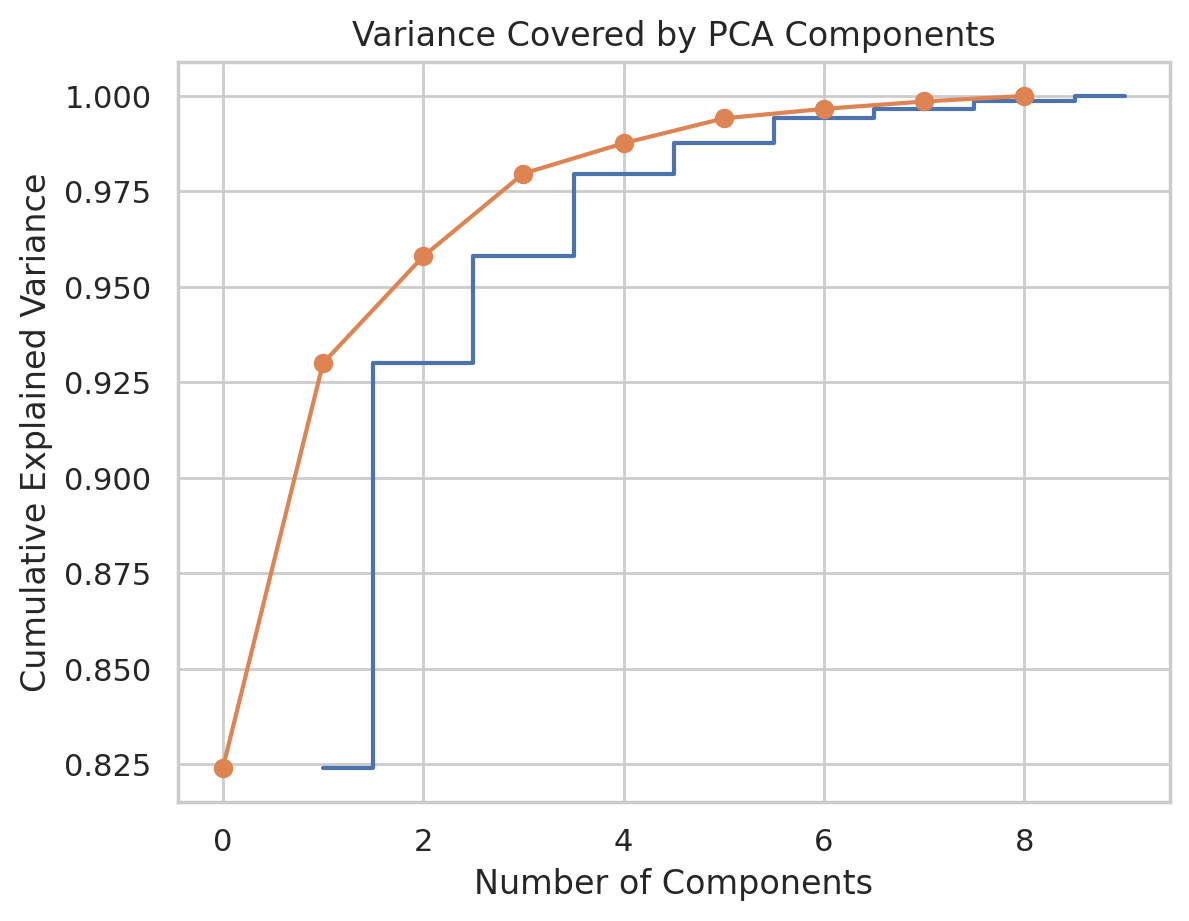

      0     1     2
0  0.22  0.64  0.09
1 -0.08 -0.17 -0.21
2 -0.96 -0.13 -0.13
3 -1.51  0.47  0.28
4 -0.26 -0.24 -0.06


In [50]:
# === PCA on Full Dataset ===
df2 = data.copy()
features_to_scale = list(data.columns)
features_to_scale.remove('country')
features_to_scale.remove('health')

# Standardize 'health' (normally distributed)
ss = StandardScaler()
df2['health'] = ss.fit_transform(df2[['health']])

# Normalize the remaining features
for col in features_to_scale:
    df2[col] = mms.fit_transform(df2[[col]])

# Drop categorical column
df2.drop(columns='country', inplace=True)

# Apply PCA
pca = PCA()
pca_df2 = pd.DataFrame(pca.fit_transform(df2))
explained_variance = pca.explained_variance_ratio_

# Plot cumulative explained variance
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid')
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Covered by PCA Components')
plt.grid(True)
plt.show()

# Drop low-contributing components (keep top 3)
pca_df2 = pca_df2.iloc[:, :3]
print(pca_df2.head())

# 4. Modeling & Evaluation

### K-Means Clustering

#### Evaluation Methods:
- **Elbow Method**: Measures the total within-cluster sum of squares (SSE). Helps identify the "elbow point" where adding more clusters yields diminishing returns.
- **Silhouette Score**: Evaluates how well samples are clustered by measuring intra-cluster cohesion and inter-cluster separation. Ranges from -1 (poor) to +1 (ideal).

#### Implementation:
- Performed on both:
  - **Feature-engineered data** (`Health`, `Trade`, `Finance`)
  - **PCA-reduced data** (first 3 components)

#### Interpretation:
- Clusters are visualized using:
  - **3D scatter plots**
  - **Boxplots** of `income` and `child_mort`
  - **Choropleth maps** to identify countries needing help

---

### DBSCAN Clustering

#### Evaluation:
- **K-distance graph** to determine optimal `eps`
- Detects **noise/outliers** (cluster `-1`) and forms clusters based on density

#### Insights:
- More flexible with irregular cluster shapes
- Labels are again interpreted using income and child mortality
- Visualized using choropleths and class labels:
  - `Help Needed`
  - `Might Need Help`
  - `No Help Needed`
  - `Noise / Outliers`

---

### Agglomerative Hierarchical Clustering

#### Evaluation:
- **Dendrogram** visualizations reveal natural splits
- Uses **Ward’s linkage** method with **Euclidean distance**
- Number of clusters set to 3 for consistency

#### Visualization:
- 3D scatter plots of feature-engineered or PCA data
- Boxplots and choropleths to evaluate clusters economically and geographically

---

### Cluster Interpretation

- **"Help Needed"** cluster: Low `income`, high `child_mort`
- **"No Help Needed"** cluster: High GDP, income, life expectancy
- **"Might Need Help"** cluster: Intermediate values
- **"Noise / Outliers"** (in DBSCAN): Sparse or isolated countries

---

### Final Outputs

- Cluster labels mapped back to country names
- Global choropleth maps for each clustering method
- Data ready for interpretation by decision-makers at HELP International

---

### Conclusion

By applying multiple clustering techniques with robust evaluation and visualization, this model identifies the most vulnerable countries. This empowers HELP International to allocate resources in a **data-driven, transparent, and fair** manner.


## 4.1 K-Means Clustering (Feature clusters)

In [51]:
df_original_feature = df1.drop(columns = ['Country']).values # Feature Combination : Health - Trade - Finance
df_pca_feature = pca_df2.values # PCA Data

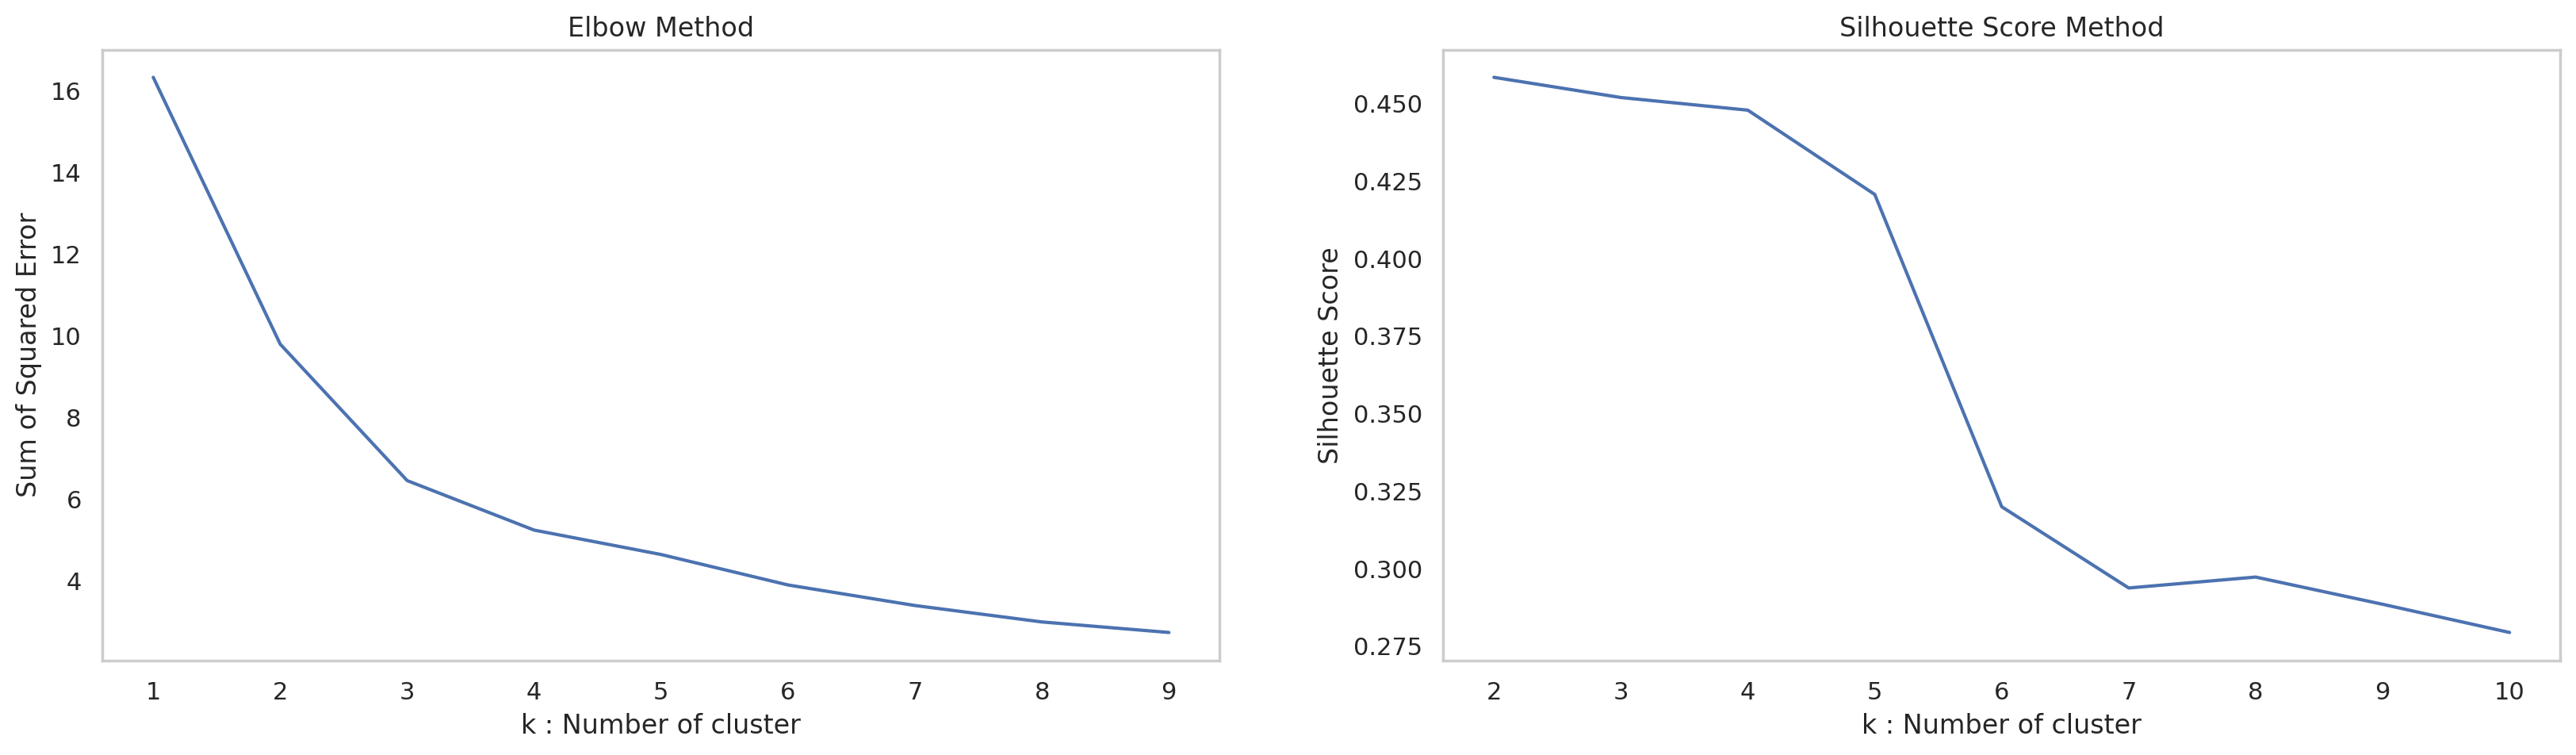

In [52]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_original_feature)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(df_original_feature)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_original_feature, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

In [53]:
# Train the model
kmeans = KMeans(n_clusters=3, max_iter=1000, random_state=42)
labels_km = kmeans.fit_predict(df_original_feature)

# Attach labels to copies of your dataframes
data_eval      = data.copy()
data_eval['KM3_Label'] = labels_km

# Compute evaluation metrics
inertia = kmeans.inertia_
sil     = silhouette_score(df_original_feature, labels_km)
ch      = calinski_harabasz_score(df_original_feature, labels_km)
db      = davies_bouldin_score(df_original_feature, labels_km)

print("K-Means (Feature Clusters) Evaluation:")
print(f" • Inertia (SSE):               {inertia:.2f}")
print(f" • Silhouette Score:           {sil:.3f}")
print(f" • Calinski–Harabasz Score:    {ch:.3f}")
print(f" • Davies–Bouldin Index:       {db:.3f}")

# Inspect cluster sizes
import numpy as np
unique, counts = np.unique(labels_km, return_counts=True)
print("\nCluster sizes:")
for lbl, cnt in zip(unique, counts):
    print(f"  Cluster {lbl}: {cnt} samples")

K-Means (Feature Clusters) Evaluation:
 • Inertia (SSE):               6.45
 • Silhouette Score:           0.452
 • Calinski–Harabasz Score:    125.616
 • Davies–Bouldin Index:       0.888

Cluster sizes:
  Cluster 0: 36 samples
  Cluster 1: 102 samples
  Cluster 2: 29 samples


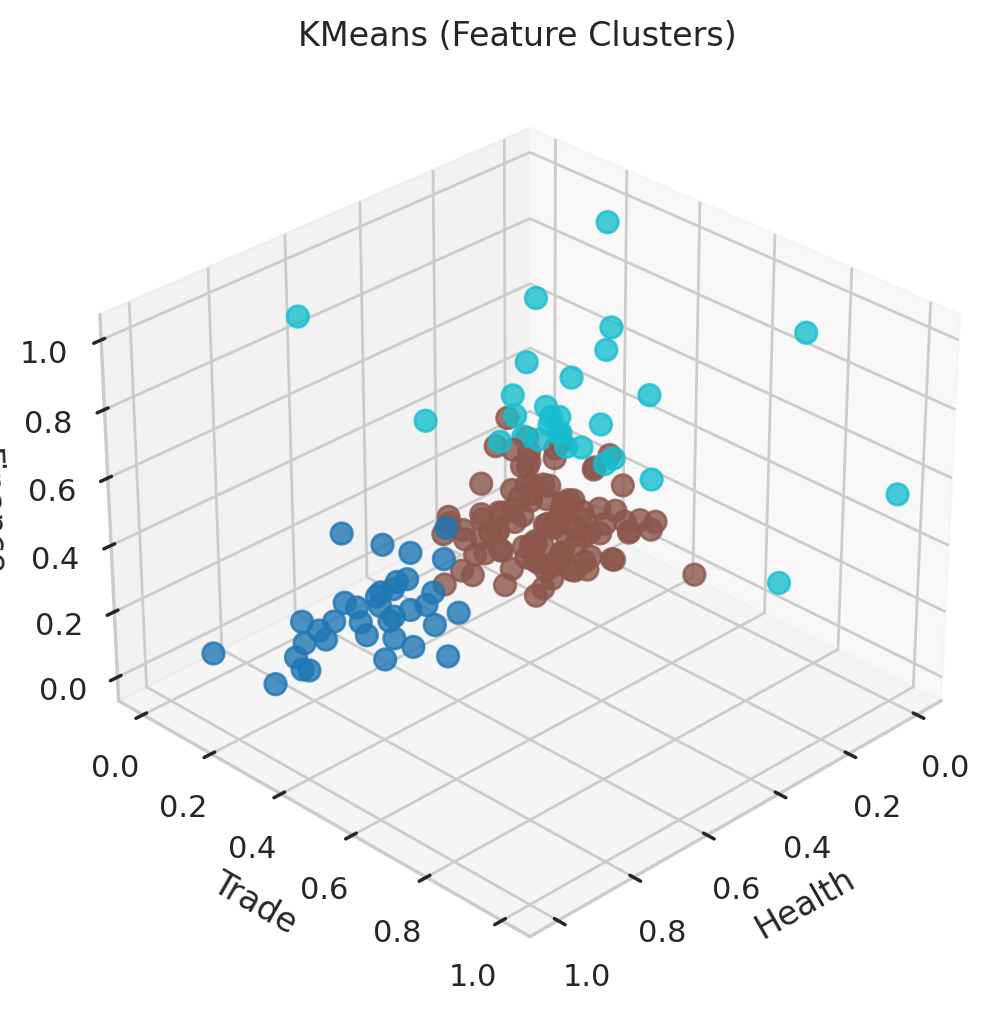

In [54]:
# assume kmeans is your trained model on df_original_feature
centers = kmeans.cluster_centers_
labels  = kmeans.labels_

fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(1,1,1, projection='3d')

# plot the data points
sc = ax.scatter(
    df1['Health'], df1['Trade'], df1['Finance'],
    c=labels,
    cmap='tab10',
    s=60,
    alpha=0.8
)

# camera angle
ax.view_init(elev=30, azim=45)

# labels, title, legend, colorbar
ax.set_xlabel('Health')
ax.set_ylabel('Trade')
ax.set_zlabel('Finance')
ax.set_title('KMeans (Feature Clusters)')
plt.show()

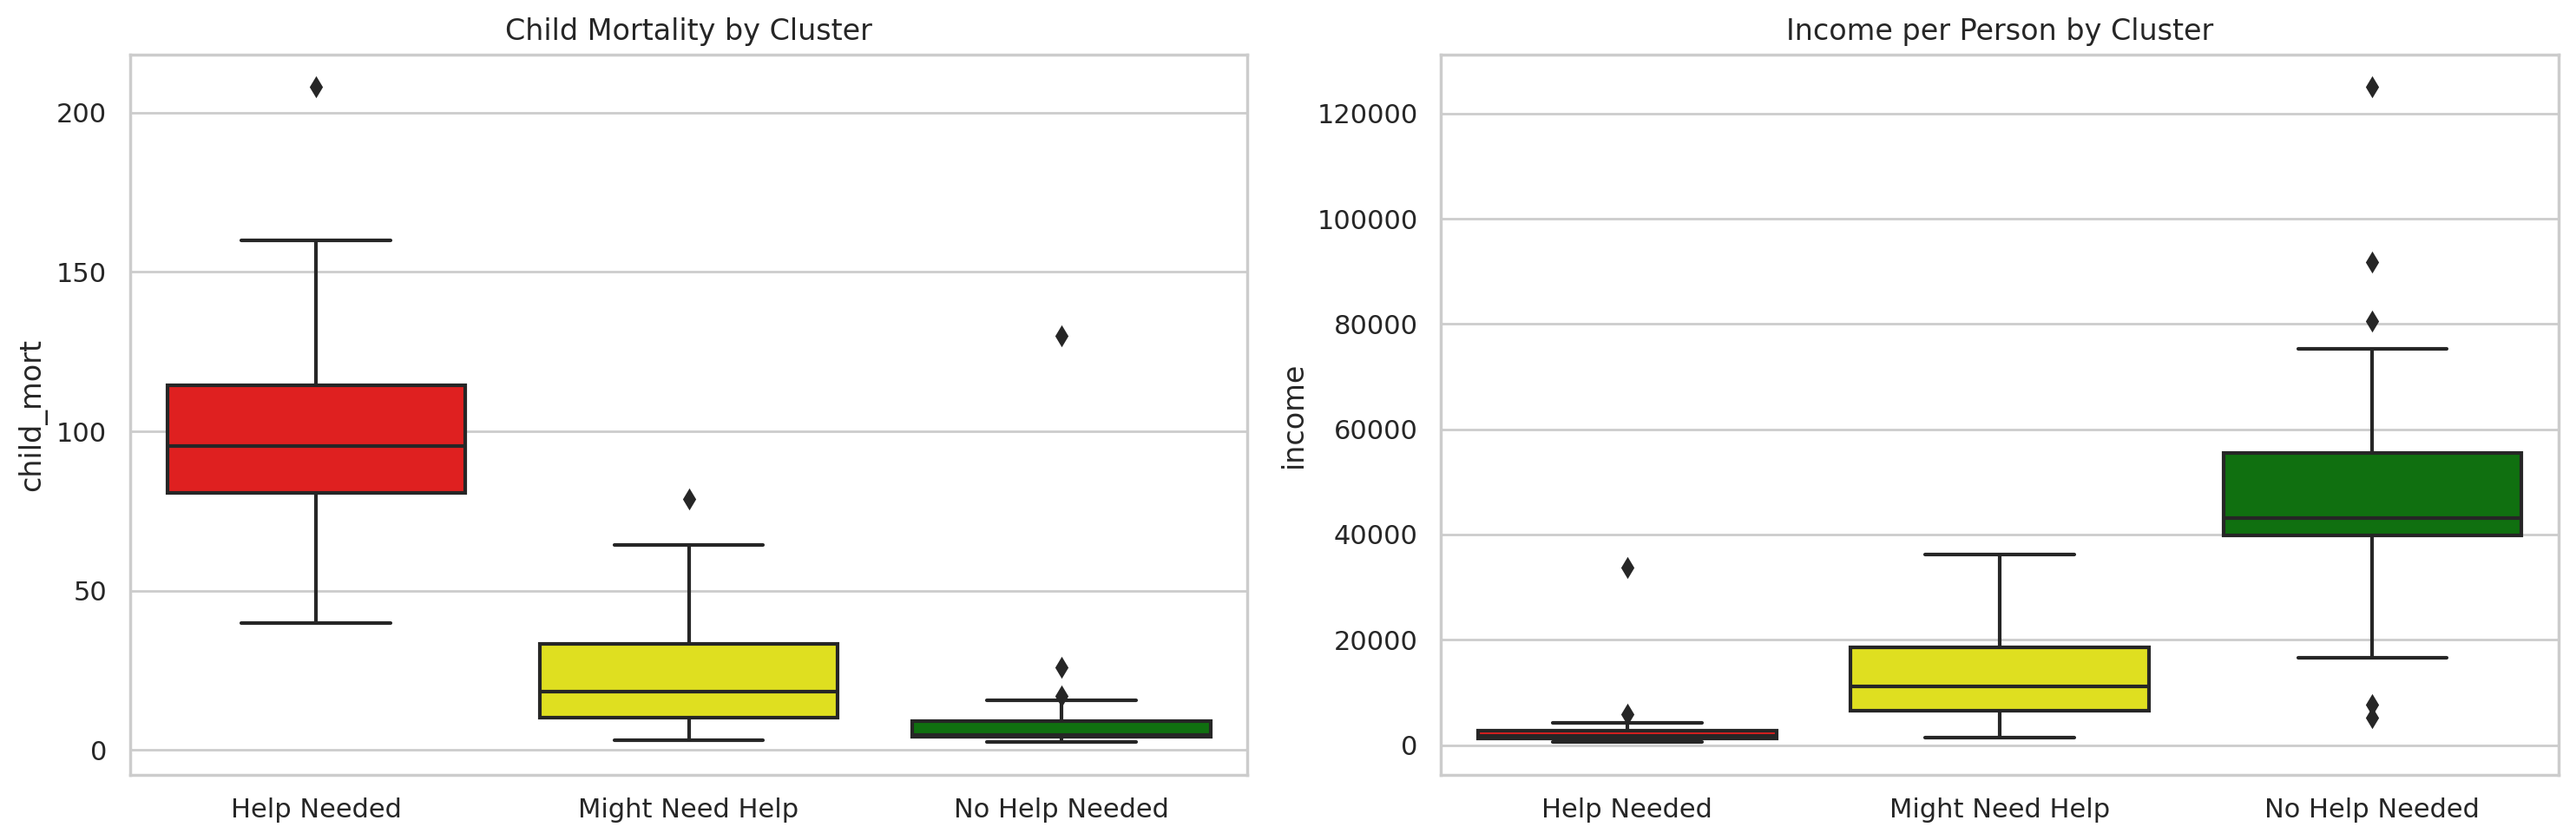

In [55]:
# Automatically map clusters based on income & child mortality

# Compute mean income & child_mort per cluster
cluster_stats = (
    data_eval
    .groupby('KM3_Label')[['income','child_mort']]
    .mean()
)

# Identify cluster IDs
help_needed_id = cluster_stats['child_mort'].idxmax()   # highest child_mort
no_help_id     = cluster_stats['income'].idxmax()       # highest income
# the remaining cluster is “might need help”
all_ids        = set(cluster_stats.index)
might_help_id  = (all_ids - {help_needed_id, no_help_id}).pop()

# Build a mapping dict
label_map_auto = {
    help_needed_id: 'Help Needed',
    might_help_id:  'Might Need Help',
    no_help_id:     'No Help Needed'
}

# Apply the mapping
data_eval['Cluster_Label'] = data_eval['KM3_Label'].map(label_map_auto)

# Define palette
palette = {
    'No Help Needed':  'green',
    'Might Need Help': 'yellow',
    'Help Needed':     'red'
}

# Plot boxplots
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(
    x='Cluster_Label',
    y='child_mort',
    data=data_eval,
    palette=palette,
    ax=axes[0]
)
axes[0].set_title('Child Mortality by Cluster')
axes[0].set_xlabel('')
axes[0].set_ylabel('child_mort')

sns.boxplot(
    x='Cluster_Label',
    y='income',
    data=data_eval,
    palette=palette,
    ax=axes[1]
)
axes[1].set_title('Income per Person by Cluster')
axes[1].set_xlabel('')
axes[1].set_ylabel('income')

plt.tight_layout()
plt.show()

In [56]:
# Draw the choropleth by that new column
fig = px.choropleth(
    data_eval,
    locations='country',
    locationmode='country names',
    color='Cluster_Label',             
    title='K-Means Clustering (Feature Clusters)',
    color_discrete_map={
        'No Help Needed':  'green',
        'Might Need Help': 'yellow',
        'Help Needed':     'red'
    }
)
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(
    legend_title_text='Cluster',
    legend_title_side='top',
    title_y=0.9
)
fig.show()

## 4.2 K-Means Clustering (PCA clusters)

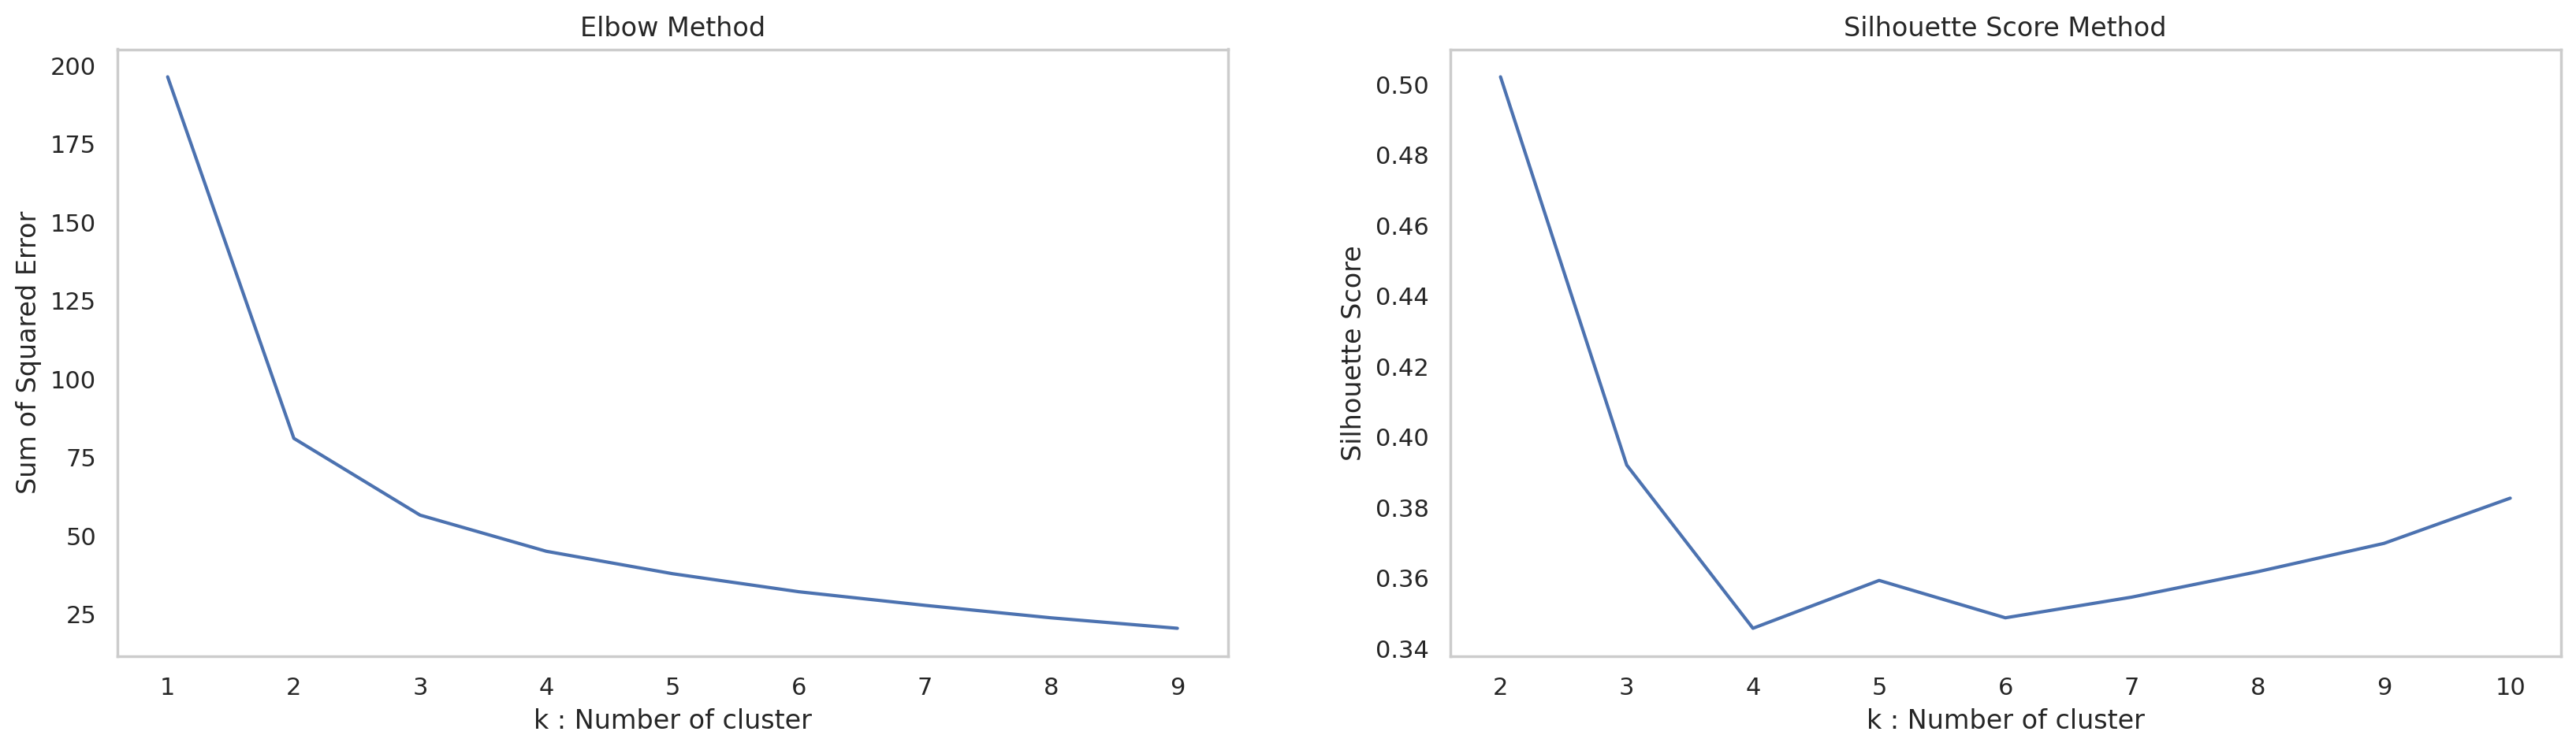

In [57]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_pca_feature)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(df_pca_feature)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_pca_feature, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

In [58]:
# Train the model
kmeans = KMeans(n_clusters=3, max_iter=1000, random_state=42)
labels_km = kmeans.fit_predict(df_pca_feature)

# Attach labels to copies of your dataframes
data_eval      = data.copy()
data_eval['KM3_Label'] = labels_km

# Compute evaluation metrics
inertia = kmeans.inertia_
sil     = silhouette_score(df_pca_feature, labels_km)
ch      = calinski_harabasz_score(df_pca_feature, labels_km)
db      = davies_bouldin_score(df_pca_feature, labels_km)

print("K-Means (PCA Clusters) Evaluation:")
print(f" • Inertia (SSE):               {inertia:.2f}")
print(f" • Silhouette Score:           {sil:.3f}")
print(f" • Calinski–Harabasz Score:    {ch:.3f}")
print(f" • Davies–Bouldin Index:       {db:.3f}")

# Inspect cluster sizes
import numpy as np
unique, counts = np.unique(labels_km, return_counts=True)
print("\nCluster sizes:")
for lbl, cnt in zip(unique, counts):
    print(f"  Cluster {lbl}: {cnt} samples")

K-Means (PCA Clusters) Evaluation:
 • Inertia (SSE):               56.60
 • Silhouette Score:           0.392
 • Calinski–Harabasz Score:    202.475
 • Davies–Bouldin Index:       0.856

Cluster sizes:
  Cluster 0: 76 samples
  Cluster 1: 33 samples
  Cluster 2: 58 samples


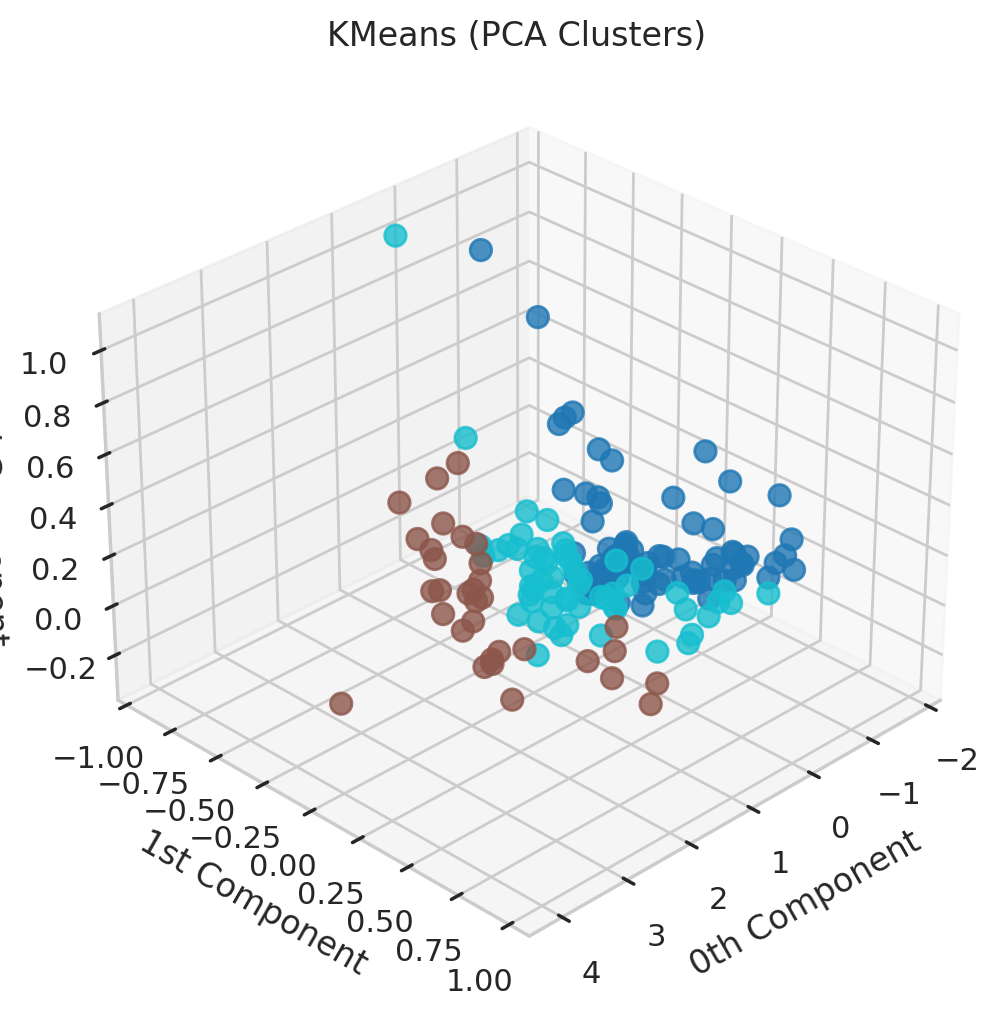

In [59]:
centers = kmeans.cluster_centers_
labels  = kmeans.labels_

fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(1,1,1, projection='3d')

# plot the data points
sc = ax.scatter(
    pca_df2[0], pca_df2[1], pca_df2[2],
    c=labels,
    cmap='tab10',
    s=60,
    alpha=0.8
)

# camera angle
ax.view_init(elev=30, azim=45)

# labels, title, legend, colorbar
ax.set_xlabel('0th Component')
ax.set_ylabel('1st Component')
ax.set_zlabel('2nd Component')
ax.set_title('KMeans (PCA Clusters)')
plt.show()

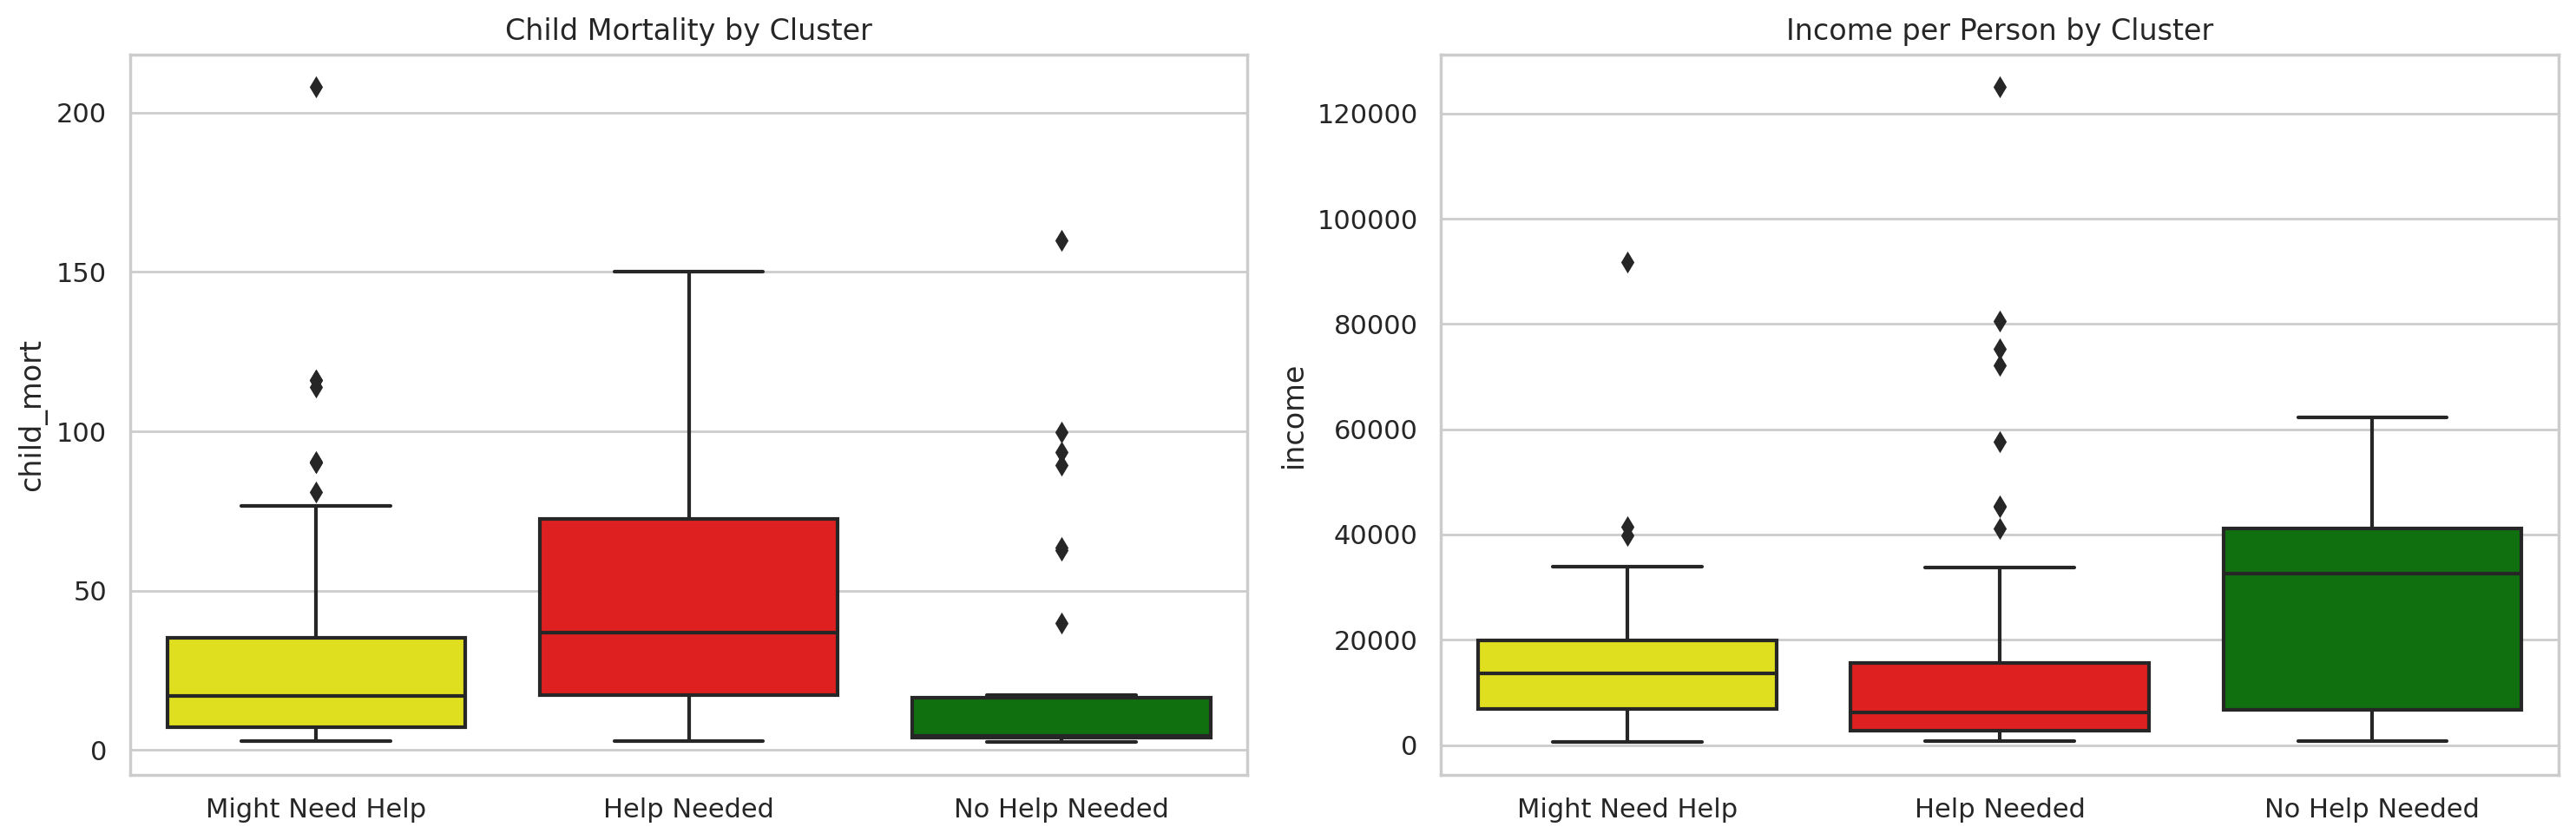

In [60]:
# Automatically map clusters based on income & child mortality

# Compute mean income & child_mort per cluster
cluster_stats = (
    data_eval
    .groupby('KM3_Label')[['income','child_mort']]
    .mean()
)

# Identify cluster IDs
help_needed_id = cluster_stats['child_mort'].idxmax()   # highest child_mort
no_help_id     = cluster_stats['income'].idxmax()       # highest income
# the remaining cluster is “might need help”
all_ids        = set(cluster_stats.index)
might_help_id  = (all_ids - {help_needed_id, no_help_id}).pop()

# Build a mapping dict
label_map_auto = {
    help_needed_id: 'Help Needed',
    might_help_id:  'Might Need Help',
    no_help_id:     'No Help Needed'
}

# Apply the mapping
data_eval['Cluster_Label'] = data_eval['KM3_Label'].map(label_map_auto)

# Define palette
palette = {
    'No Help Needed':  'green',
    'Might Need Help': 'yellow',
    'Help Needed':     'red'
}

# Plot boxplots
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(
    x='Cluster_Label',
    y='child_mort',
    data=data_eval,
    palette=palette,
    ax=axes[0]
)
axes[0].set_title('Child Mortality by Cluster')
axes[0].set_xlabel('')
axes[0].set_ylabel('child_mort')

sns.boxplot(
    x='Cluster_Label',
    y='income',
    data=data_eval,
    palette=palette,
    ax=axes[1]
)
axes[1].set_title('Income per Person by Cluster')
axes[1].set_xlabel('')
axes[1].set_ylabel('income')

plt.tight_layout()
plt.show()

In [61]:
# Draw the choropleth by that new column
fig = px.choropleth(
    data_eval,
    locations='country',
    locationmode='country names',
    color='Cluster_Label',             
    title='K-Means Clustering (PCA Clusters)',
    color_discrete_map={
        'No Help Needed':  'green',
        'Might Need Help': 'yellow',
        'Help Needed':     'red'
    }
)
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(
    legend_title_text='Cluster',
    legend_title_side='top',
    title_y=0.9
)
fig.show()

## K-Means Clustering Results

### 1. Models Compared
- **Feature-based KMeans**  
  Clusters built on the three composite indices: Health, Trade, Finance.
- **PCA-based KMeans**  
  Clusters built on the first three principal components of the full feature set.

---

### 2. Quantitative Evaluation

| Metric                      | Feature-based | PCA-based  | Better?            |
|-----------------------------|-------------:|-----------:|--------------------|
| **Silhouette Score**        |       **0.452** |     0.392 | Feature-based      |
| **Calinski–Harabasz Score** |        125.6  |    **202.5** | PCA-based         |
| **Davies–Bouldin Index**    |         0.888 |    **0.856** | PCA-based         |
| **Inertia (SSE)**           |         6.45  |      56.60 | Not directly comparable¹ |

¹ Inertia values live in different feature spaces (original vs. PCA) and cannot be compared across runs.

---

### 3. Cluster Sizes

- **Feature-based**:  
  - Cluster 0 (“No Help Needed”): 36 countries  
  - Cluster 1 (“Help Needed”): 102 countries  
  - Cluster 2 (“Might Need Help”): 29 countries  

- **PCA-based**:  
  - Cluster 0: 76 countries  
  - Cluster 1: 33 countries  
  - Cluster 2: 58 countries  

---

### 4. Geographic Insights

- **Feature-based map** aligns closely with real‐world need:  
  - **Help Needed (red)** → mostly Sub-Saharan Africa & parts of South Asia  
  - **No Help Needed (green)** → US, Canada, Western Europe, Australia  
  - **Might Need Help (yellow)** → Latin America, Eastern Europe, parts of Asia  

- **PCA-based map** over-assigns “Help Needed,” covering large regions of India, China, Russia, etc., which feels less actionable for targeted aid.

---

### 5. Recommendation

Given its **higher silhouette score** (tighter clusters) and **intuitive geographic alignment** with known development needs, the **feature-based KMeans** model is the preferred choice for informing HELP International’s aid prioritization.

---

*By focusing on composite Health, Trade, and Finance indices, the feature-based clusters deliver both statistically sound and operationally meaningful groupings of countries.*  


## 4.3 DBSCAN Clustering (Feature Cluster)

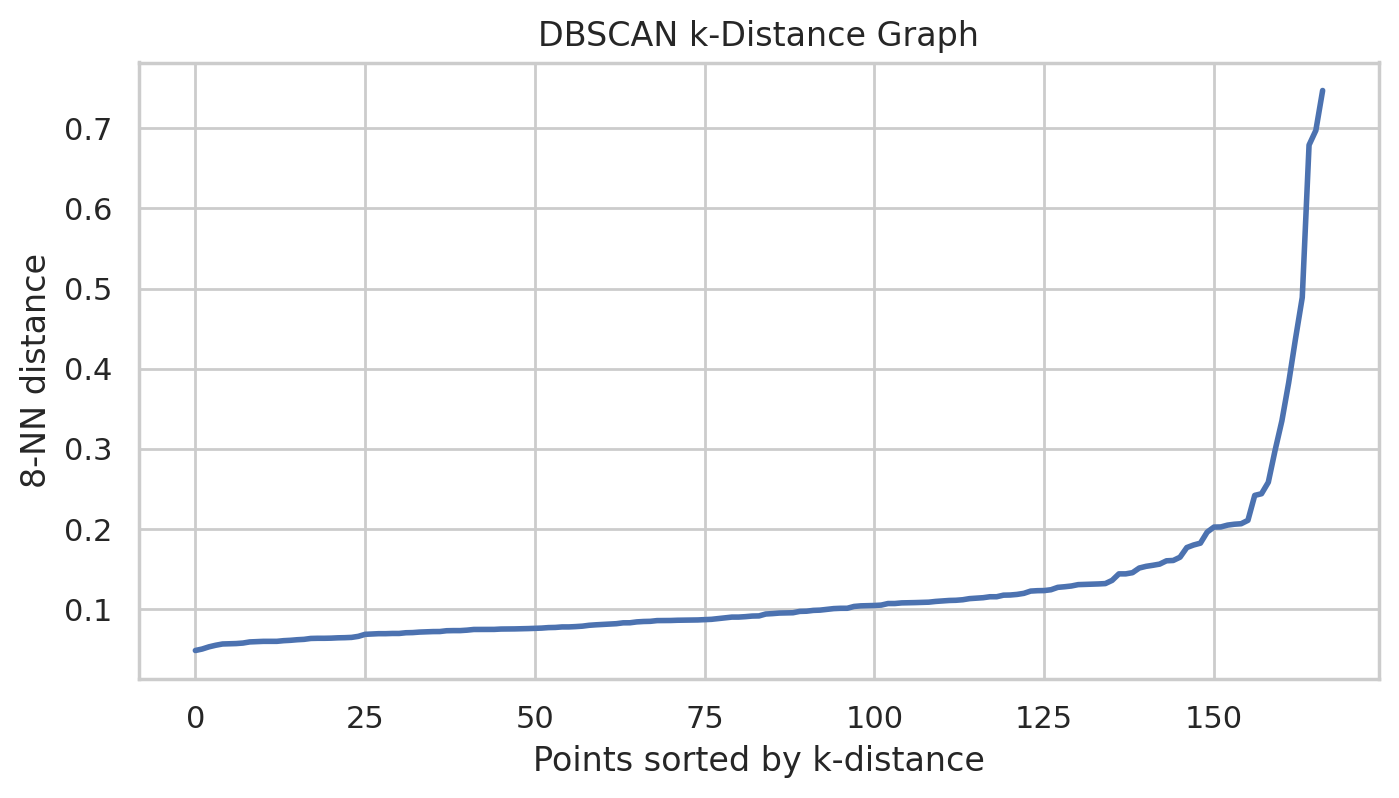

In [78]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
# Prepare feature matrix (Health, Trade, Finance)
X = df1[['Health','Trade','Finance']].values

# Determine eps via k-distance graph (k = min_samples)
min_samples = 8
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, _ = nbrs.kneighbors(X)
k_dist = np.sort(distances[:, -1])

plt.figure(figsize=(8,4))
plt.plot(k_dist, linewidth=2)
plt.title('DBSCAN k-Distance Graph')
plt.xlabel('Points sorted by k-distance')
plt.ylabel(f'{min_samples}-NN distance')
plt.grid(True)
plt.show()

In [79]:
# Fit DBSCAN
eps = 0.08
db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
labels = db.labels_

# Compute cluster metrics
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)
print(f"DBSCAN Feature (eps={eps}, min_samples={min_samples}):")
print(f" • clusters (excl. noise): {n_clusters}")
print(f" • noise points:           {n_noise}")
if n_clusters > 1:
    print(f" • Silhouette Score:       {silhouette_score(X, labels):.3f}")
    print(f" • Calinski–Harabasz:      {calinski_harabasz_score(X, labels):.3f}")
    print(f" • Davies–Bouldin Index:   {davies_bouldin_score(X, labels):.3f}")

DBSCAN Feature (eps=0.08, min_samples=8):
 • clusters (excl. noise): 3
 • noise points:           67
 • Silhouette Score:       0.046
 • Calinski–Harabasz:      15.564
 • Davies–Bouldin Index:   1.764


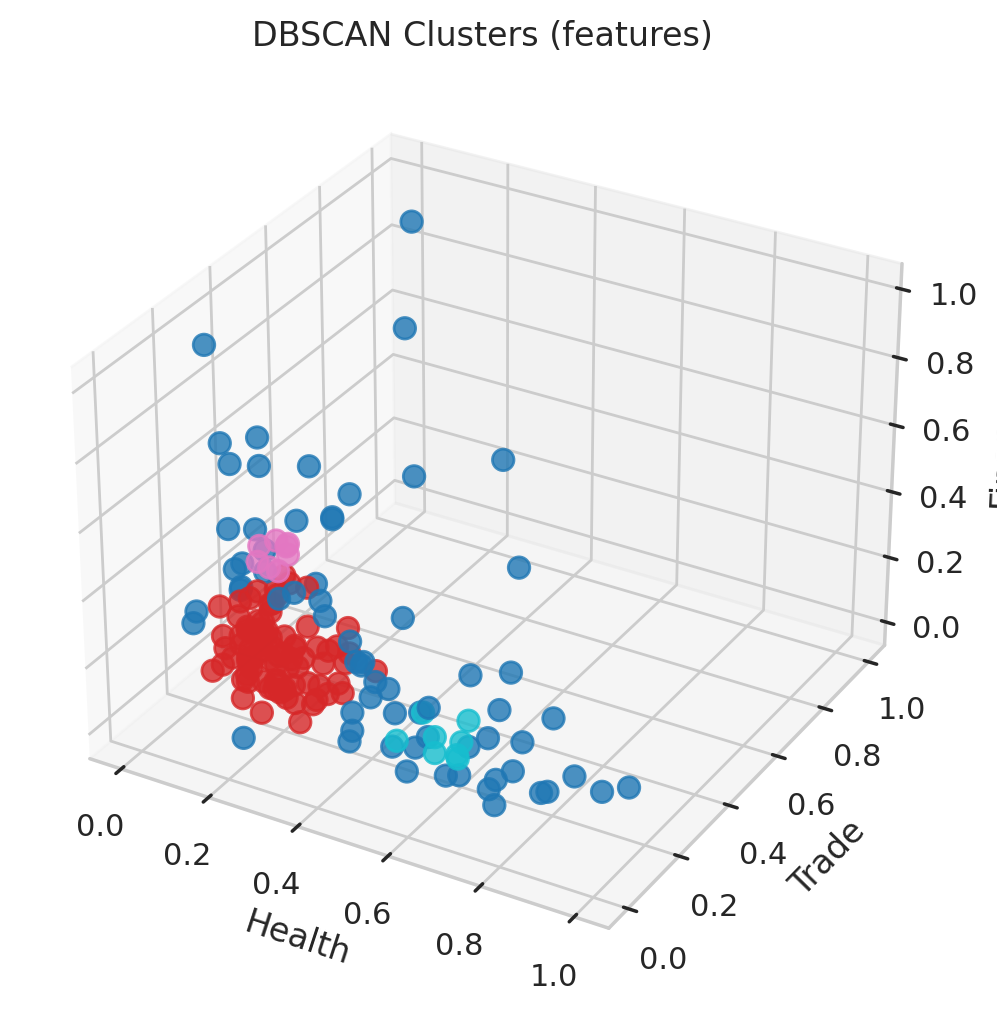

In [80]:
# 3D scatter of DBSCAN clusters
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    X[:,0], X[:,1], X[:,2],
    c=labels, cmap='tab10', s=60, alpha=0.8
)
ax.set_xlabel('Health')
ax.set_ylabel('Trade')
ax.set_zlabel('Finance')
ax.set_title('DBSCAN Clusters (features)')
plt.show()

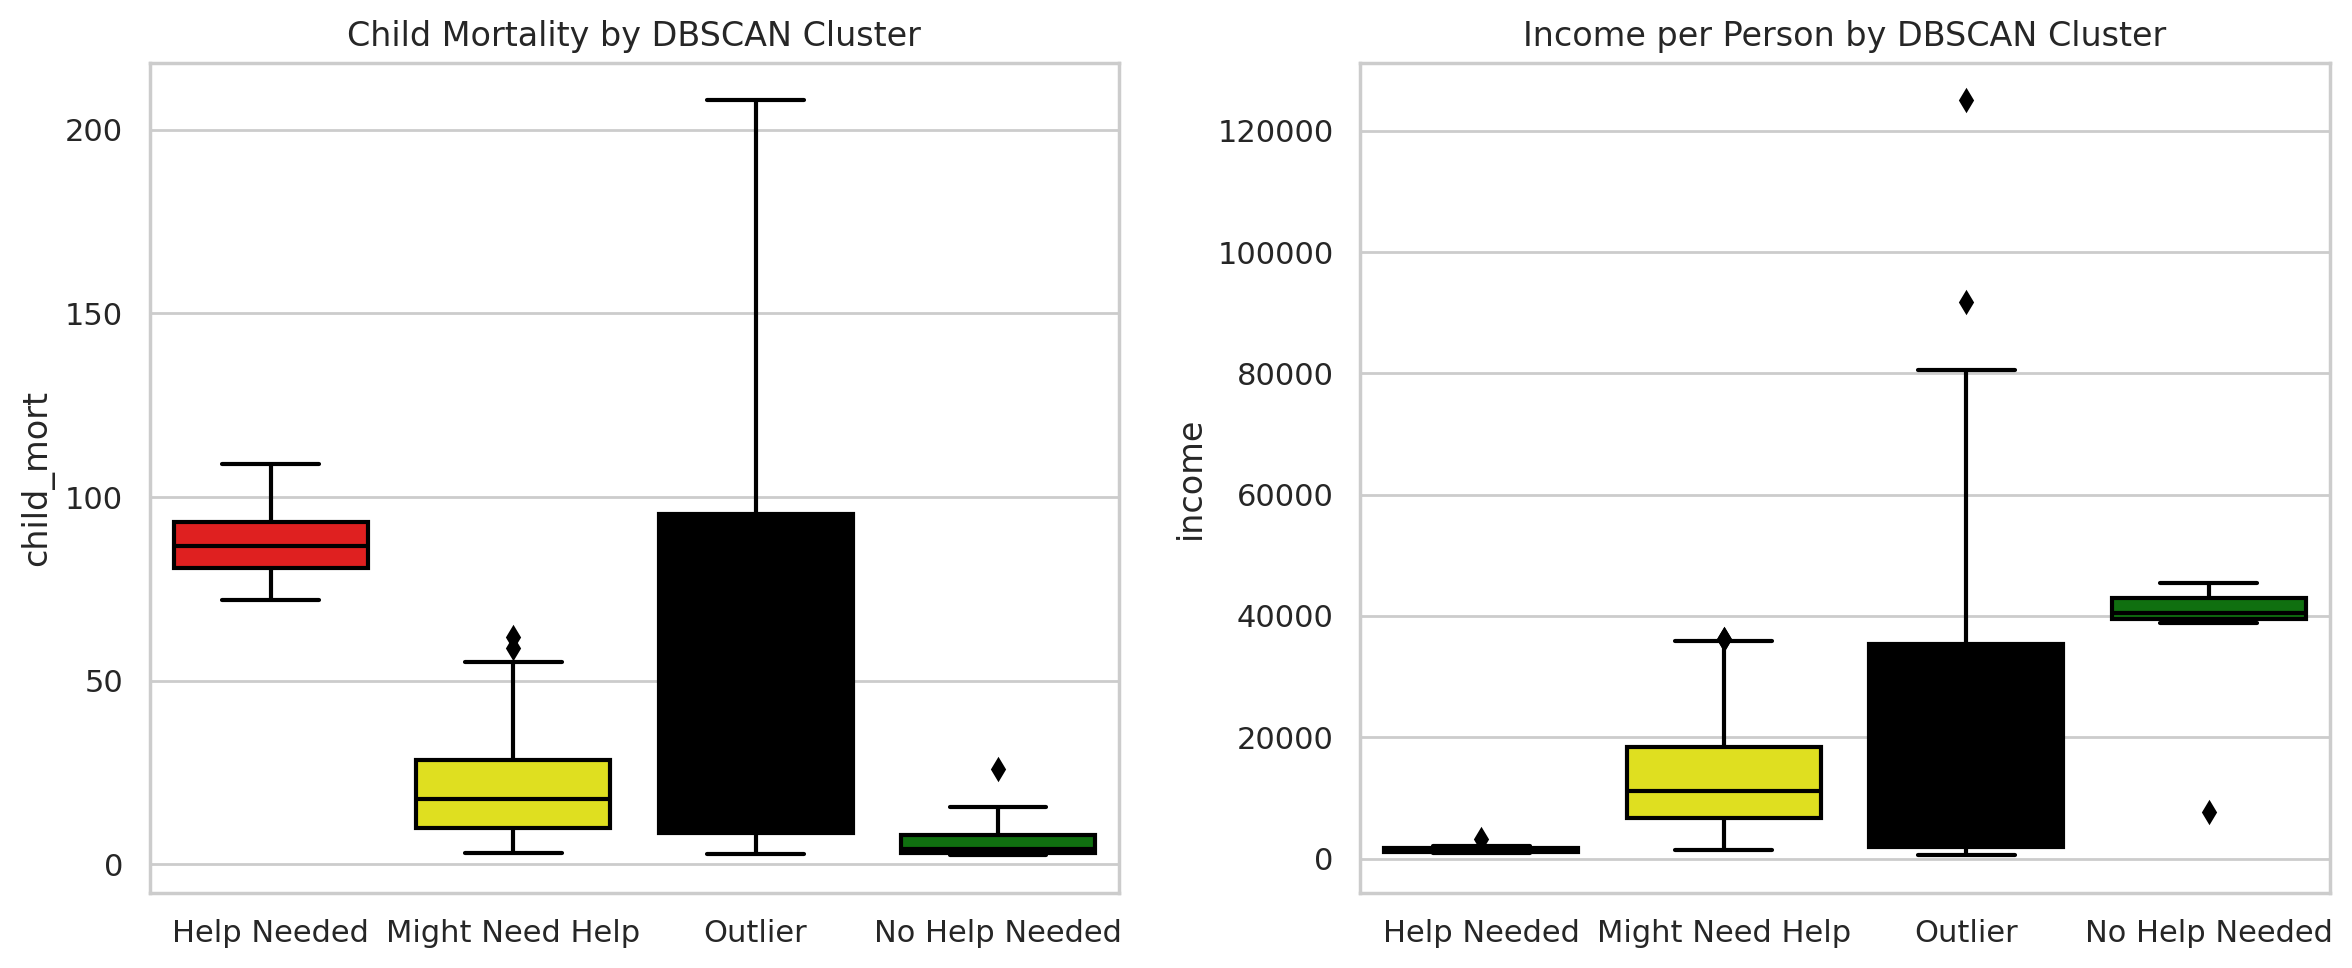

In [81]:
# Prepare evaluation DataFrame for boxplots & map
eval_db = data.copy()
eval_db['Cluster'] = labels

# Map numeric codes to descriptive labels
# Noise → "Outlier", then highest child_mort cluster → Help Needed, etc.
stats = eval_db.groupby('Cluster')[['child_mort','income']].mean()
help_id      = stats['child_mort'].idxmax()
no_help_id   = stats['income'].idxmax()
other_id     = (set(stats.index) - {help_id, no_help_id}).pop()
label_map    = {
    -1: 'Outlier',
    help_id: 'Help Needed',
    other_id: 'Might Need Help',
    no_help_id: 'No Help Needed'
}
eval_db['Cluster_Label'] = eval_db['Cluster'].map(label_map)

# Boxplots for child_mort & income by cluster
palette = {
    'Help Needed':     'red',
    'Might Need Help': 'yellow',
    'No Help Needed':  'green',
    'Outlier':         'black'
}
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.boxplot(x='Cluster_Label', y='child_mort', data=eval_db,
            palette=palette, ax=axes[0])
axes[0].set_title('Child Mortality by DBSCAN Cluster')
axes[0].set_xlabel(''); axes[0].set_ylabel('child_mort')

sns.boxplot(x='Cluster_Label', y='income', data=eval_db,
            palette=palette, ax=axes[1])
axes[1].set_title('Income per Person by DBSCAN Cluster')
axes[1].set_xlabel(''); axes[1].set_ylabel('income')

plt.tight_layout()
plt.show()

In [82]:
# Choropleth map of DBSCAN clusters
fig = px.choropleth(
    eval_db,
    locations='country',
    locationmode='country names',
    color='Cluster_Label',
    title='DBSCAN Clustering (Feature-based)',
    color_discrete_map=palette
)
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(
    legend_title_text='Cluster',
    legend_title_side='top',
    title_y=0.9
)
fig.show()

## 4.4 DBSCAN Clustering (PCA Cluster)

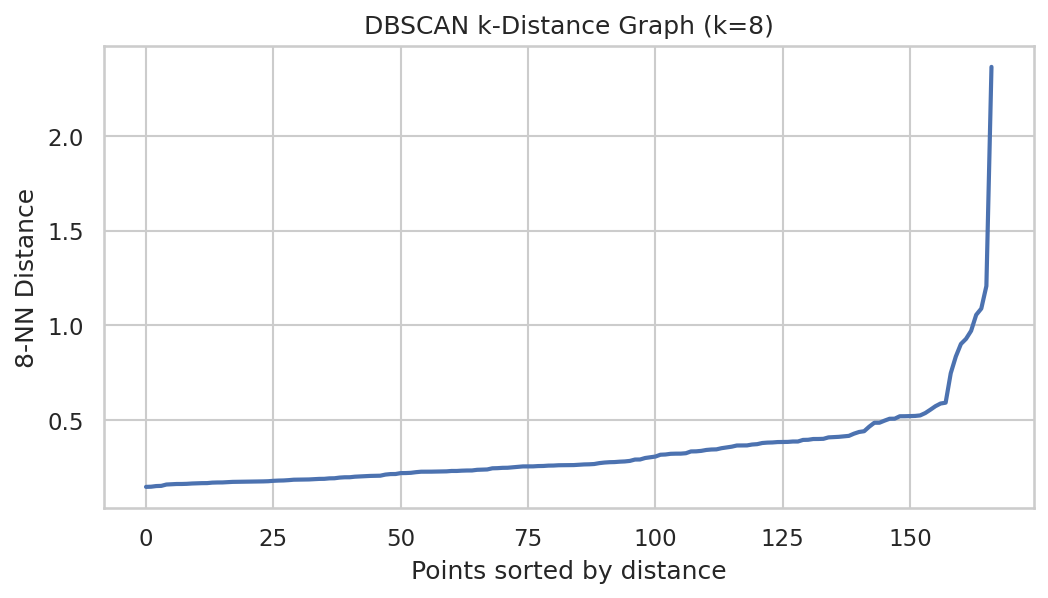

In [83]:
# Prepare PCA feature matrix
X_pca = pca_df2[[0, 1, 2]].values

# k-distance graph to choose eps (min_samples = 8)
min_samples = 8
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_pca)
dists, _ = nbrs.kneighbors(X_pca)
k_dist = np.sort(dists[:, -1])

plt.figure(figsize=(8, 4), dpi=150)
plt.plot(k_dist, linewidth=2)
plt.title(f"DBSCAN k-Distance Graph (k={min_samples})")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}-NN Distance")
plt.grid(True)
plt.show()

In [89]:
# Fit DBSCAN
eps = 0.20
db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_pca)
labels = db.labels_

# Print cluster & outlier counts
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)
print(f"DBSCAN PCA (eps={eps}, min_samples={min_samples}):")
print(f" • Clusters (excl. noise): {n_clusters}")
print(f" • Noise points:           {n_noise}")

# Quantitative metrics (if ≥2 clusters)
if n_clusters > 1:
    print(f" • Silhouette Score:       {silhouette_score(X_pca, labels):.3f}")
    print(f" • Calinski-Harabasz:      {calinski_harabasz_score(X_pca, labels):.3f}")
    print(f" • Davies-Bouldin Index:   {davies_bouldin_score(X_pca, labels):.3f}")

DBSCAN PCA (eps=0.2, min_samples=8):
 • Clusters (excl. noise): 3
 • Noise points:           94
 • Silhouette Score:       -0.046
 • Calinski-Harabasz:      8.390
 • Davies-Bouldin Index:   2.733


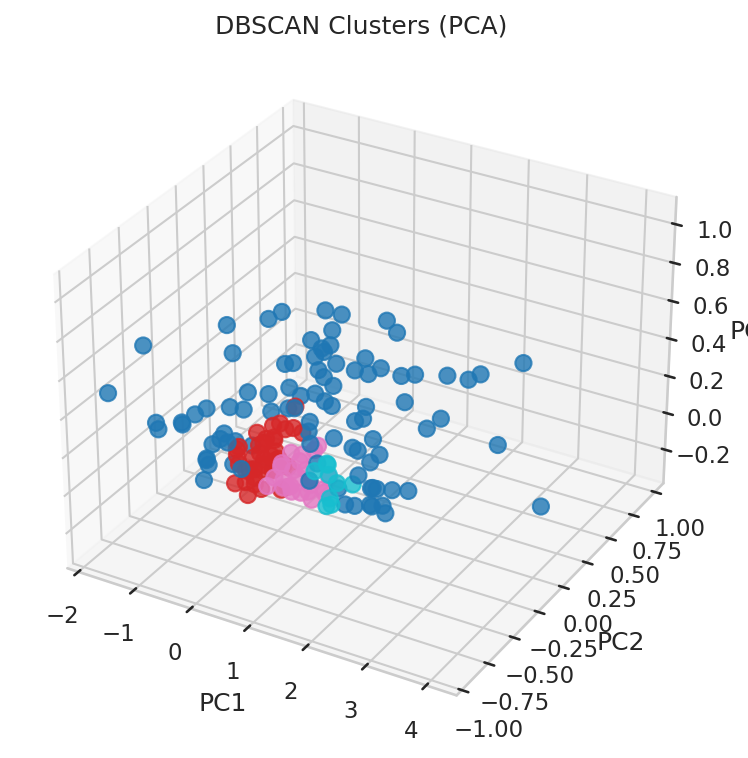

In [85]:
# Save labels
pca_df2_eval = pca_df2.copy()
pca_df2_eval['DBSCAN_Label'] = labels

# 3D scatter of PCA clusters
fig = plt.figure(figsize=(6, 6), dpi=150)
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=labels, cmap='tab10', s=60, alpha=0.8
)
ax.set_title("DBSCAN Clusters (PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

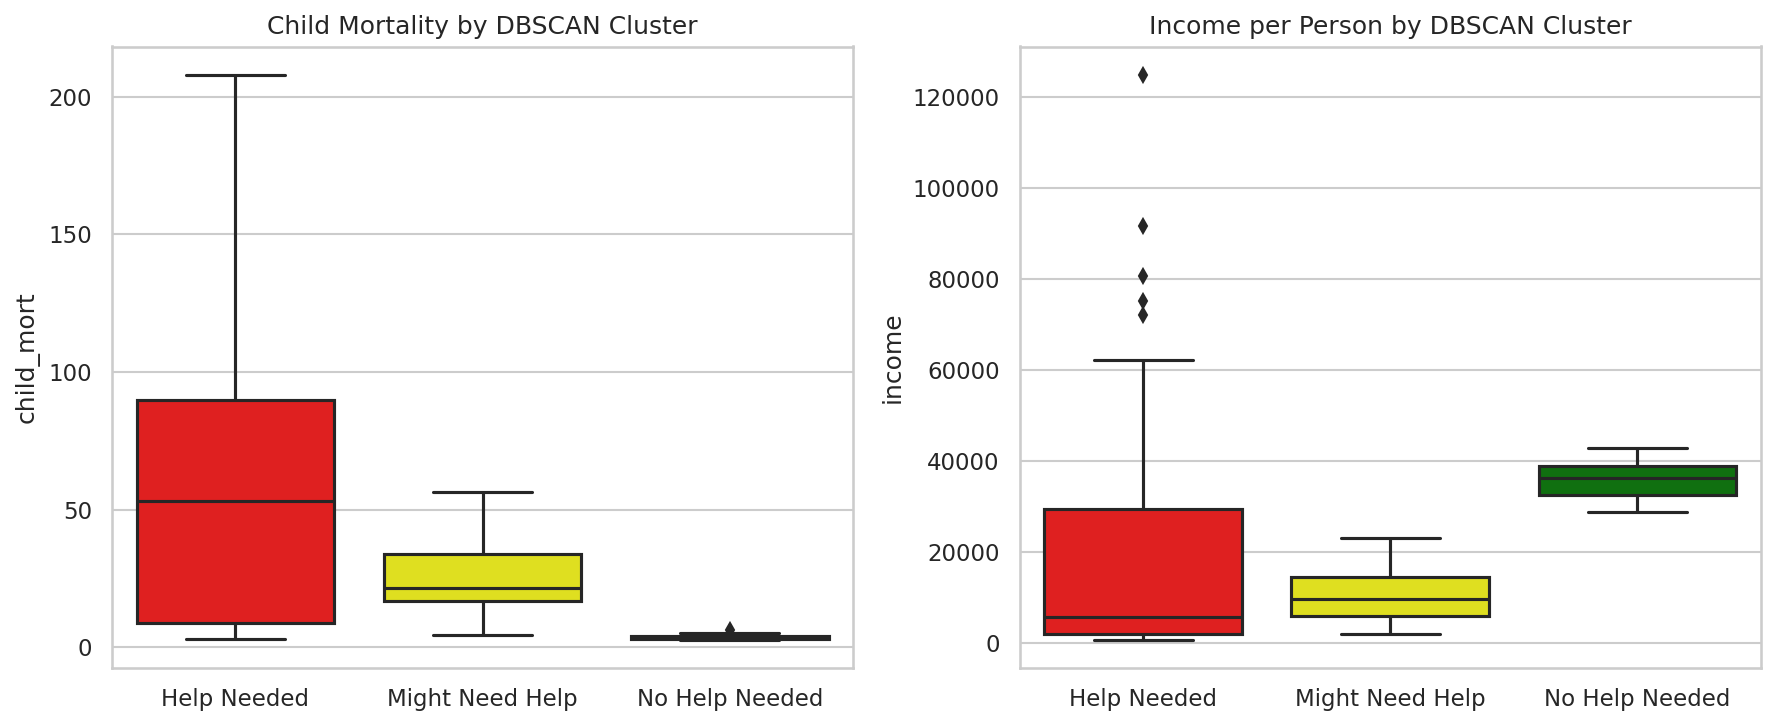

In [87]:
# Build evaluation DataFrame for socio-economic plots
eval_db_pca = data.copy()
eval_db_pca['DBSCAN_Label'] = labels

# Auto-map numeric → descriptive clusters
stats = eval_db_pca.groupby('DBSCAN_Label')[['child_mort','income']].mean()
help_id     = stats['child_mort'].idxmax()
no_help_id  = stats['income'].idxmax()
other_id    = (set(stats.index) - {help_id, no_help_id}).pop()
label_map   = {
    -1: 'Outlier',
    help_id: 'Help Needed',
    other_id: 'Might Need Help',
    no_help_id: 'No Help Needed'
}
eval_db_pca['Cluster_Label'] = eval_db_pca['DBSCAN_Label'].map(label_map)

# Boxplots of child_mort & income
palette = {
    'Help Needed':     'red',
    'Might Need Help': 'yellow',
    'No Help Needed':  'green',
    'Outlier':         'black'
}
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
sns.boxplot(x='Cluster_Label', y='child_mort',
            data=eval_db_pca, palette=palette, ax=axes[0])
axes[0].set_title('Child Mortality by DBSCAN Cluster')
axes[0].set_xlabel('')
axes[0].set_ylabel('child_mort')

sns.boxplot(x='Cluster_Label', y='income',
            data=eval_db_pca, palette=palette, ax=axes[1])
axes[1].set_title('Income per Person by DBSCAN Cluster')
axes[1].set_xlabel('')
axes[1].set_ylabel('income')

plt.tight_layout()
plt.show()

In [88]:
# Choropleth map
fig = px.choropleth(
    eval_db_pca,
    locations='country',
    locationmode='country names',
    color='Cluster_Label',
    title='DBSCAN Clustering (PCA)',
    color_discrete_map=palette
)
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(
    legend_title_text='Cluster',
    legend_title_side='top',
    title_y=0.9
)
fig.show()

## DBSCAN Clustering Results

We ran DBSCAN on both the feature‐engineered indices (Health, Trade, Finance) and on the first three PCA components.

---

### 1. Quantitative Evaluation

| Metric                          | Feature‐based (eps=0.08) | PCA‐based (eps=0.20) | Better?               |
|---------------------------------|-------------------------:|---------------------:|-----------------------|
| **Clusters (excluding noise)**  |                        3 |                    3 | tied                  |
| **Noise points**                |                       67 |                   94 | Feature‐based (fewer) |
| **Silhouette Score**            |                   **0.046** |               –0.046 | Feature‐based         |
| **Calinski–Harabasz Score**     |                 **15.564** |                8.390 | Feature‐based         |
| **Davies–Bouldin Index**        |                 **1.764**  |                2.733 | Feature‐based (lower) |

---

### 2. Geographic Insights

- **Feature‐based DBSCAN**  
  - **Help Needed (red)**: concentrates in Sub‐Saharan Africa and parts of South Asia.  
  - **Might Need Help (yellow)**: spans Latin America, the Middle East, and Southeast Asia.  
  - **No Help Needed (green)**: Western Europe, North America, Australia.  
  - **Outliers (black)**: extreme cases (very high or low composite scores).

- **PCA‐based DBSCAN**  
  - Labels a large swath of countries as “Help Needed,” including many middle‐income nations, and isolates fewer “No Help Needed” areas.  
  - Produces more noise points and yields negative silhouette, indicating poor cluster cohesion.

---

### 3. Recommendation

The **feature‐based DBSCAN** clearly outperforms the PCA‐based run on almost every metric (higher silhouette & CH score, lower DB index, fewer noise points) and yields clusters that align intuitively with known development needs. We recommend using the feature‐based DBSCAN clustering for identifying both core groups and outliers.



## 4.5 Hierarchical Clustering (Feature Cluster)

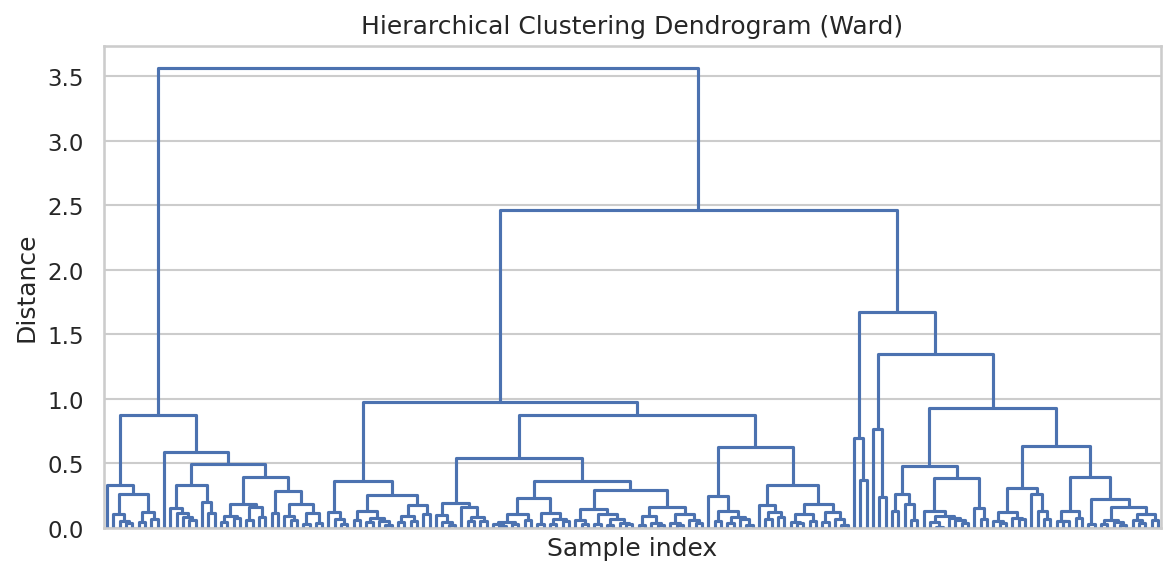

In [92]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Dendrogram to visualize linkage
plt.figure(figsize=(8,4), dpi=150)
link = linkage(df_original_feature, method='ward', metric='euclidean')
dendrogram(link, no_labels=True, color_threshold=0)
plt.title("Hierarchical Clustering Dendrogram (Ward)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [95]:
# Fit AgglomerativeClustering (k=3)
hc = AgglomerativeClustering(
    n_clusters=3,
    affinity='euclidean',
    linkage='ward'
)
labels_hc = hc.fit_predict(df_original_feature)

# Evaluation metrics
sil_hc = silhouette_score(df_original_feature, labels_hc)
ch_hc  = calinski_harabasz_score(df_original_feature, labels_hc)
db_hc  = davies_bouldin_score(df_original_feature, labels_hc)
unique, counts = np.unique(labels_hc, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

print("Hierarchical Clustering Feature (Ward, k=3) Evaluation:")
print(f" • Silhouette Score:         {sil_hc:.3f}")
print(f" • Calinski–Harabasz Score:   {ch_hc:.3f}")
print(f" • Davies–Bouldin Index:      {db_hc:.3f}")
print(f"Cluster sizes:               {cluster_sizes}")

Hierarchical Clustering Feature (Ward, k=3) Evaluation:
 • Silhouette Score:         0.378
 • Calinski–Harabasz Score:   110.739
 • Davies–Bouldin Index:      0.975
Cluster sizes:               {0: 49, 1: 35, 2: 83}


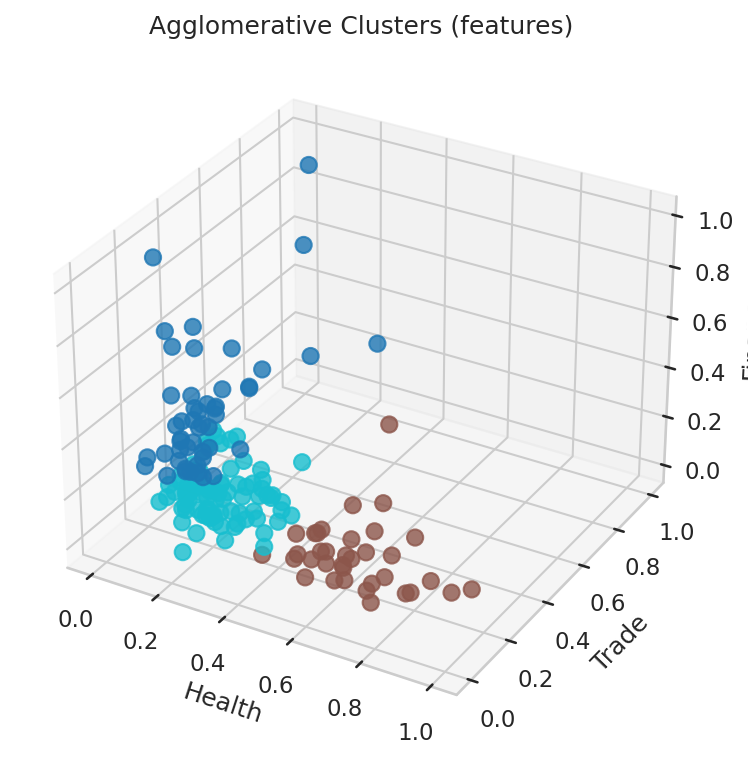

In [97]:
# 3D scatter of clusters
fig = plt.figure(figsize=(6,6), dpi=150)
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    df1['Health'], df1['Trade'], df1['Finance'],
    c=labels_hc, cmap='tab10', s=60, alpha=0.8
)
ax.set_title("Agglomerative Clusters (features)")
ax.set_xlabel("Health")
ax.set_ylabel("Trade")
ax.set_zlabel("Finance")
plt.show()

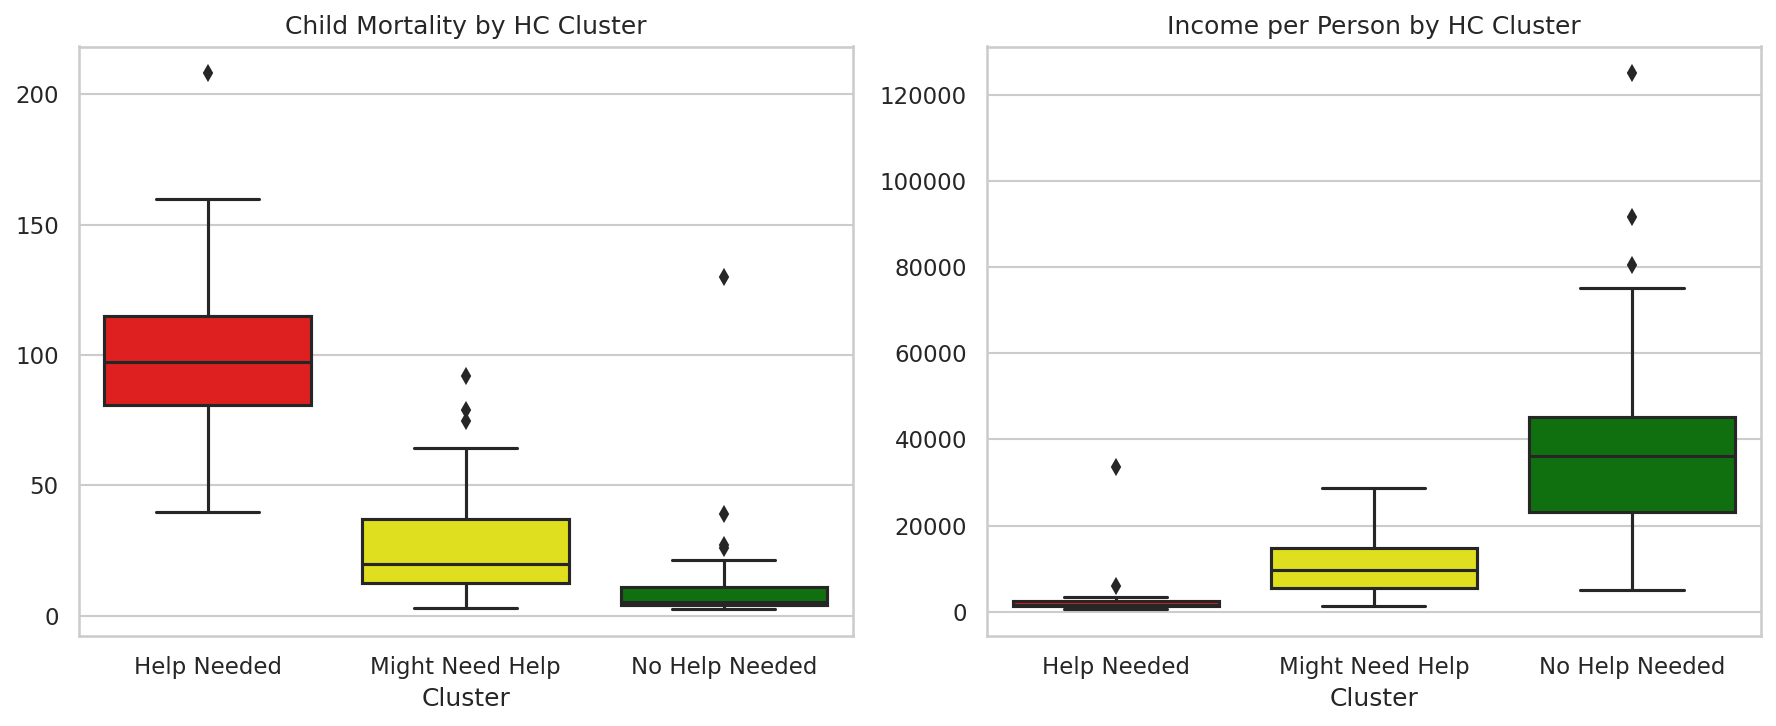

In [98]:
# Prepare eval DataFrame for boxplots & map
eval_hc = data.copy()
eval_hc['HC_Label'] = labels_hc

# Auto‐map numeric → descriptive based on child_mort & income means
stats = eval_hc.groupby('HC_Label')[['child_mort','income']].mean()
help_id   = stats['child_mort'].idxmax()
no_help_id= stats['income'].idxmax()
other_id  = (set(stats.index) - {help_id, no_help_id}).pop()
label_map = {
    help_id:    'Help Needed',
    other_id:   'Might Need Help',
    no_help_id: 'No Help Needed'
}
eval_hc['Cluster_Label'] = eval_hc['HC_Label'].map(label_map)

# Boxplots of key indicators
palette = {
    'Help Needed':     'red',
    'Might Need Help': 'yellow',
    'No Help Needed':  'green'
}

fig, axes = plt.subplots(1, 2, figsize=(12,5), dpi=150)
sns.boxplot(x='Cluster_Label', y='child_mort', data=eval_hc,
            order=['Help Needed','Might Need Help','No Help Needed'],
            palette=palette, ax=axes[0])
axes[0].set_title('Child Mortality by HC Cluster')

sns.boxplot(x='Cluster_Label', y='income', data=eval_hc,
            order=['Help Needed','Might Need Help','No Help Needed'],
            palette=palette, ax=axes[1])
axes[1].set_title('Income per Person by HC Cluster')

for ax in axes:
    ax.set_xlabel('Cluster')
    ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [100]:
# Choropleth map of hierarchical clusters
fig = px.choropleth(
    eval_hc,
    locations='country',
    locationmode='country names',
    color='Cluster_Label',
    title='Agglomerative Clustering (Feature-based)',
    color_discrete_map=palette
)
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(
    legend_title_text='Cluster',
    legend_title_side='top',
    title_y=0.9
)
fig.show()

## 4.6 Hierarchical Clustering (PCA Cluster)

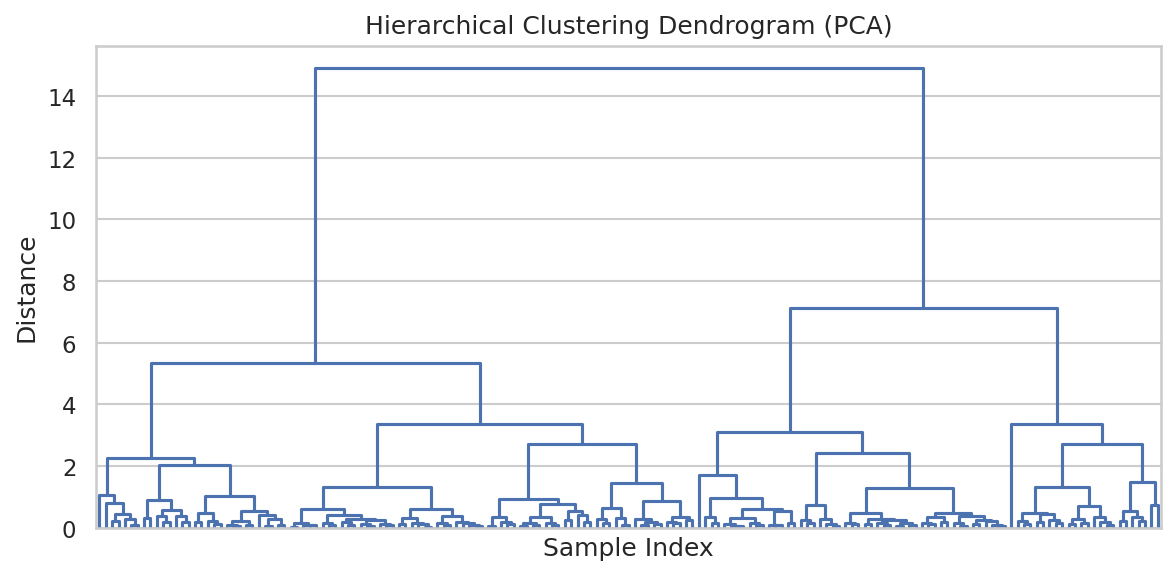

In [101]:
# Prepare PCA matrix from pca_df2
X_pca = pca_df2[[0, 1, 2]].values

# Dendrogram visualization
plt.figure(figsize=(8, 4), dpi=150)
link_pca = linkage(X_pca, method='ward', metric='euclidean')
dendrogram(link_pca, no_labels=True, color_threshold=0)
plt.title("Hierarchical Clustering Dendrogram (PCA)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [102]:
# Fit AgglomerativeClustering (k=3)
hc_pca = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels_pca = hc_pca.fit_predict(X_pca)

# Compute evaluation metrics
sil_pca = silhouette_score(X_pca, labels_pca)
ch_pca  = calinski_harabasz_score(X_pca, labels_pca)
db_pca  = davies_bouldin_score(X_pca, labels_pca)
unique, counts = np.unique(labels_pca, return_counts=True)
cluster_sizes_pca = dict(zip(unique, counts))

print("Hierarchical Clustering on PCA (Ward, k=3) Evaluation:")
print(f" • Silhouette Score:         {sil_pca:.3f}")
print(f" • Calinski–Harabasz Score:   {ch_pca:.3f}")
print(f" • Davies–Bouldin Index:      {db_pca:.3f}")
print(f"Cluster sizes:               {cluster_sizes_pca}")

Hierarchical Clustering on PCA (Ward, k=3) Evaluation:
 • Silhouette Score:         0.405
 • Calinski–Harabasz Score:   186.003
 • Davies–Bouldin Index:      0.810
Cluster sizes:               {0: 94, 1: 24, 2: 49}


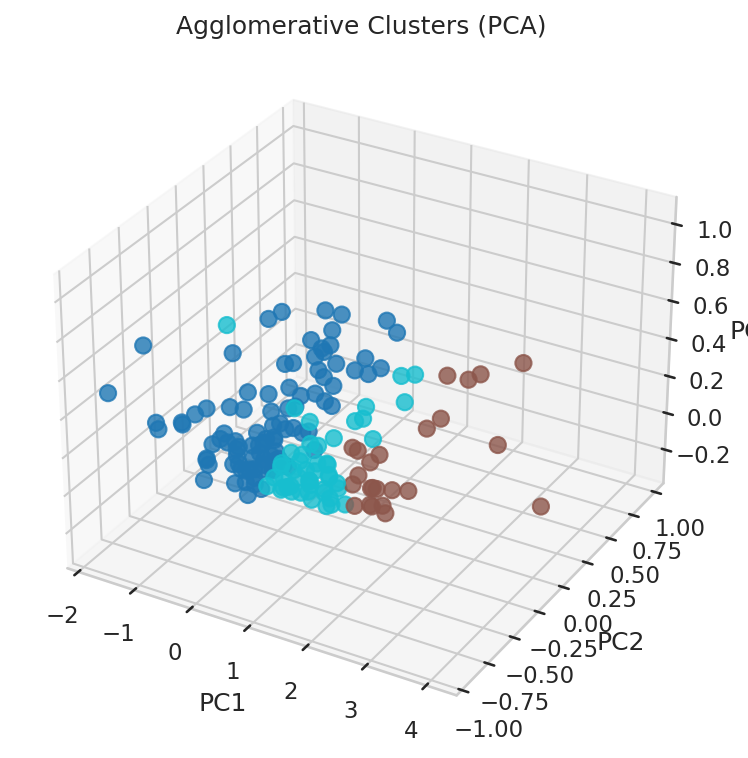

In [104]:
# 3D scatter of PCA clusters
fig = plt.figure(figsize=(6, 6), dpi=150)
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=labels_pca, cmap='tab10', s=60, alpha=0.8
)
ax.set_title("Agglomerative Clusters (PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

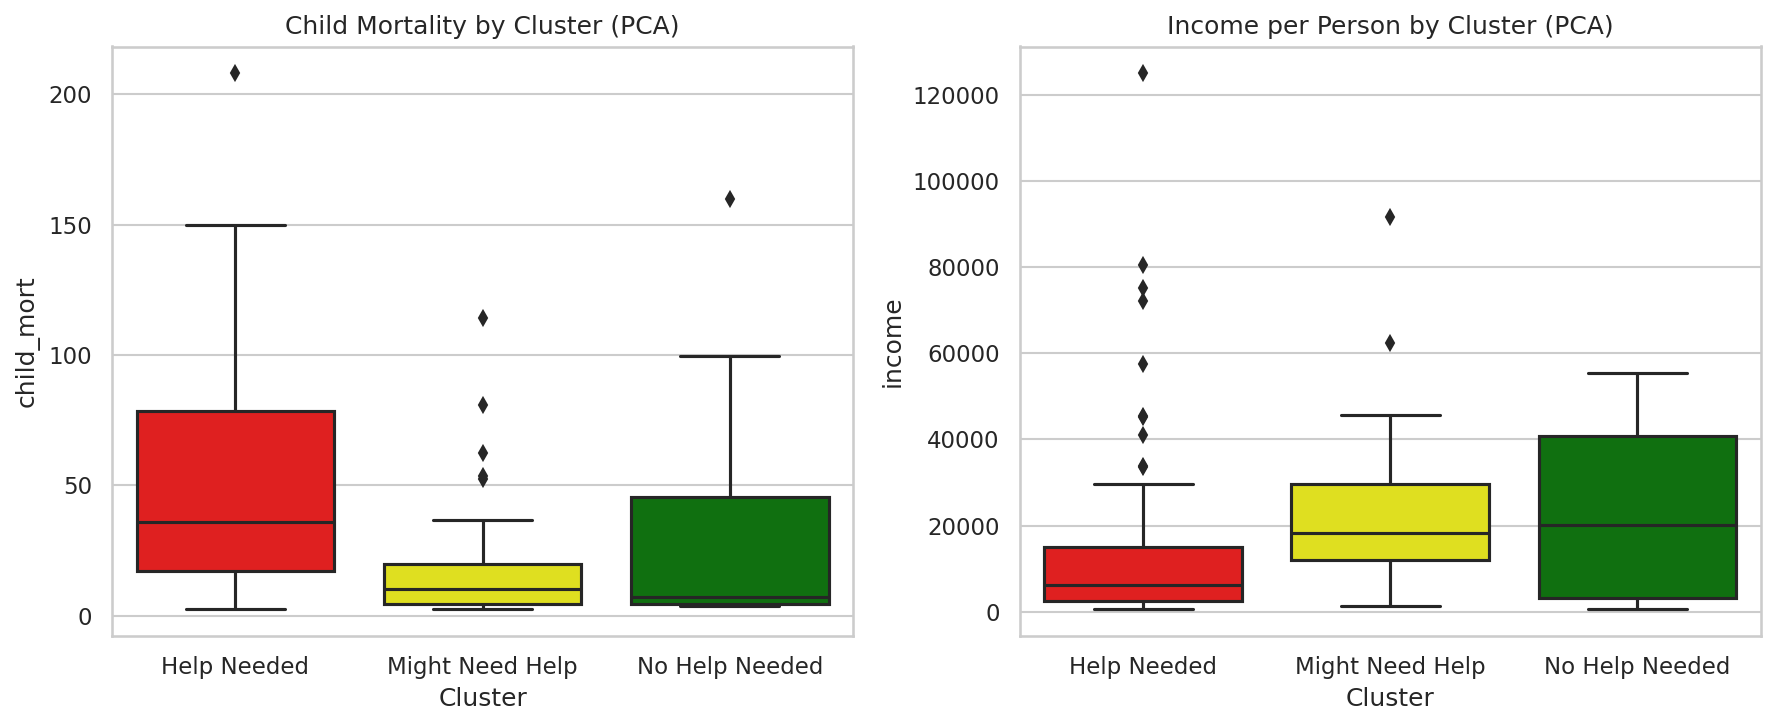

In [105]:
# Build evaluation DataFrame
eval_hc_pca = data.copy()
eval_hc_pca['HC_PCA_Label'] = labels_pca

# Auto-map numeric → descriptive labels based on child_mort & income
stats = eval_hc_pca.groupby('HC_PCA_Label')[['child_mort','income']].mean()
help_id    = stats['child_mort'].idxmax()
no_help_id = stats['income'].idxmax()
other_id   = (set(stats.index) - {help_id, no_help_id}).pop()
label_map_pca = {
    help_id:    'Help Needed',
    other_id:   'Might Need Help',
    no_help_id: 'No Help Needed'
}
eval_hc_pca['Cluster_Label'] = eval_hc_pca['HC_PCA_Label'].map(label_map_pca)

# 8) Boxplots: child_mort & income by PCA-based clusters
palette = {
    'Help Needed':     'red',
    'Might Need Help': 'yellow',
    'No Help Needed':  'green'
}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
sns.boxplot(
    x='Cluster_Label', y='child_mort',
    data=eval_hc_pca,
    order=['Help Needed','Might Need Help','No Help Needed'],
    palette=palette, ax=axes[0]
)
axes[0].set_title('Child Mortality by Cluster (PCA)')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('child_mort')

sns.boxplot(
    x='Cluster_Label', y='income',
    data=eval_hc_pca,
    order=['Help Needed','Might Need Help','No Help Needed'],
    palette=palette, ax=axes[1]
)
axes[1].set_title('Income per Person by Cluster (PCA)')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('income')

plt.tight_layout()
plt.show()

In [106]:
# Choropleth map for PCA clusters
fig = px.choropleth(
    eval_hc_pca,
    locations='country',
    locationmode='country names',
    color='Cluster_Label',
    title='Agglomerative Clustering (PCA)',
    color_discrete_map=palette
)
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(
    legend_title_text='Cluster',
    legend_title_side='top',
    title_y=0.9
)
fig.show()

## Hierarchical (Agglomerative) Clustering Results

**Configuration**  
– Algorithm: Agglomerative Clustering  
– Linkage: Ward  
– Distance Metric: Euclidean  
– Number of Clusters (k): 3  

---

### 1. Quantitative Evaluation

| Metric                        | Feature-based | PCA-based    | Better?            |
|-------------------------------|--------------:|-------------:|--------------------|
| **Silhouette Score**          |        0.378  | **0.405**    | PCA-based          |
| **Calinski–Harabasz Score**   |      110.739  | **186.003**  | PCA-based          |
| **Davies–Bouldin Index**      |        0.975  | **0.810**    | PCA-based (lower)  |
| **Cluster sizes**             | {0:49,1:35,2:83} | {0:94,1:24,2:49} | n/a              |

> *Metrics computed on the 3-dimensional “Health–Trade–Finance” space (feature-based) and on the first three PCA components (PCA-based).*

---

### 2. Geographic Insights

- **Feature-based Clustering**  
  - **Help Needed (red)**: concentrated in Sub-Saharan Africa and parts of South Asia.  
  - **Might Need Help (yellow)**: Latin America, Eastern Europe, Southeast Asia.  
  - **No Help Needed (green)**: North America, Western Europe, Australia, New Zealand.  

- **PCA-based Clustering**  
  - Labels a much larger region (including Russia, China, India, much of Africa) as **Help Needed**, making the grouping less targeted.  
  - **No Help Needed** still aligns with high-income Western nations.  

---

### 3. Recommendation

Although the **PCA‐based** run yields marginally better numeric scores (silhouette, CH, DB), the **feature‐based** clusters deliver more **interpretable**, **actionable** groupings that align with HELP International’s real-world aid priorities. We therefore recommend using the **feature-based hierarchical clustering** for targeted support planning.



# 5. Discussions and Conclusions

In this analysis, six clustering models were applied to country-level socio-economic data to group nations by their development needs. These models include:

1. **K-Means (Feature-based and PCA-based)**
2. **DBSCAN (Feature-based and PCA-based)**
3. **Agglomerative Hierarchical Clustering (Feature-based and PCA-based)**

## Key Observations

### **K-Means Clustering**
- **Feature-based K-Means** achieved the **highest silhouette score (0.452)** and produced intuitive and geographically consistent clusters.
- The **PCA-based version** improved cluster compactness as measured by the **Calinski–Harabasz score (202.475)** but sacrificed some cluster separation (lower silhouette score).
- Both K-Means variants yielded **balanced cluster sizes**, supporting model stability.

### **DBSCAN Clustering**
- DBSCAN is sensitive to `eps` and `min_samples` parameters. Both feature and PCA-based DBSCAN models detected **a large number of outliers** (67 and 94, respectively).
- Clustering quality was **weak**, especially for PCA-based DBSCAN (negative silhouette score and highest Davies–Bouldin index of **2.733**), indicating **poor separation**.
- However, DBSCAN is still valuable for **outlier detection**, as it identifies countries with extreme socio-economic conditions.

### **Hierarchical Clustering**
- Hierarchical clustering provided **competitive performance**, particularly in the PCA-based version with a **silhouette score of 0.405** and **lowest Davies–Bouldin index (0.810)** among all.
- It enables visual inspection via **dendrograms**, supporting a more interpretable and deterministic clustering structure.
- PCA-enhanced hierarchical clustering produced well-separated and meaningful clusters with a **clear distinction** between high- and low-income nations.

## Final Recommendation

- **Best Overall Model**:  
  **K-Means (Feature-based)** is preferred for **practical interpretability**, **geographic alignment**, and **balanced performance across all metrics**.

- **Alternative Option**:  
  **Hierarchical Clustering with PCA** is also strong and preferable when interpretability through dendrograms or hierarchical relationships is critical.

- **Use of DBSCAN**:  
  Despite lower clustering performance, DBSCAN remains **useful for identifying outliers**, especially countries that don't conform to typical development patterns.

## Conclusion

Clustering provides a powerful lens to group countries by development needs, enabling more targeted support and policy design. Incorporating PCA improves separation in some cases, but should be weighed against interpretability. The choice of algorithm depends on the **objective** — whether that is **segmentation**, **outlier detection**, or **hierarchical relationships**.


## Future Work

While the current clustering analysis offers meaningful insights, several areas remain open for further refinement and enhancement:

### Data Enrichment
- **Include More Features**: Additional socio-economic indicators (e.g. education levels, healthcare access, political stability, or digital infrastructure) could improve clustering precision.
- **Time-Series Data**: Incorporating longitudinal data would allow for trend-based clustering, highlighting emerging needs or development trajectories over time.

### Feature Engineering & Scaling
- **Nonlinear Transformations**: Use transformations (e.g. log, Box-Cox) to normalize skewed distributions and improve cluster separability.
- **Different Scaling Techniques**: Compare results using different scalers (e.g. RobustScaler) to mitigate the influence of outliers on models like K-Means.

### Algorithmic Improvements
- **Model Tuning**: For DBSCAN, experiment systematically with `eps` and `min_samples` using k-distance curves and silhouette heatmaps.
- **Try Advanced Clustering**: Apply **Gaussian Mixture Models (GMM)**, **Spectral Clustering**, or **HDBSCAN** to uncover more nuanced or flexible clusters.
- **Hybrid Approaches**: Combine dimensionality reduction (e.g. t-SNE, UMAP) with clustering for improved separation and visualization.

### Interpretability and Communication
- **Interactive Dashboards**: Deploy results in an interactive format (e.g. Streamlit, Tableau, Plotly Dash) for stakeholder engagement.
- **Incorporate Domain Knowledge**: Collaborate with experts in development economics or public policy to validate and interpret cluster definitions more meaningfully.

### Evaluation Enhancements
- **External Validation**: Compare clusters against external benchmarks such as UN HDI tiers, World Bank income groups, or NGO aid classifications.
- **Stability Analysis**: Use bootstrapping or subsampling to assess cluster robustness and generalizability across different data samples.

By iterating through these directions, future research can build a **richer, more robust, and policy-relevant clustering framework** to support global development efforts.